In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
#%load_ext line_profiler
import ompy as om
from pathlib import Path
import matplotlib.pyplot as plt

# New Response

In [501]:
rd = om.ResponseData.from_db('Oscar2017').normalize()
rdi = om.ResponseInterpolation.from_data(rd)

In [502]:
e = 900
intp, low, high = om.response.test_compton_lerp(rd, e)
fanned, _, _ = om.response.test_compton_fan(rd, e)
lerped, _ , _ = om.response.test_lerp_end(rd, rdi, e)
whole, _, _ = om.response.test_whole(rd, rdi, e)

TypeError: too many arguments: expected 3, got 6

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
low.plot(label='low', ax=ax)
high.plot(ax=ax, label='high')
intp.plot(ax=ax, label='lerp')
fanned.plot(ax=ax, label='fan')
lerped.plot(ax=ax, label='end lerp', linestyle='--')
whole.plot(ax=ax, label='all', linestyle=':')
x = high.last_nonzero()
ax.set_xlim(0, high.E[x])
ax.legend()
fig.savefig('compton.png', dpi=300)

In [ ]:
rd = om.ResponseData.from_db('Oscar2017').normalize()
rdi = om.ResponseInterpolation.from_data(rd)

In [ ]:
#[print(len(c), min(c.E), max(c.E), (c.de), sum(c)) for c in rd.compton]
rd.plot()

In [ ]:
E = np.linspace(200, 10000, 1000)
#E = np.linspace(300, 1000, 30)
Ec = rd.E_compton
sigma = om.Vector(E=Ec, values=rdi.sigma(Ec))
M = om.response.interpolate_compton(rd, E, sigma, nsigma=6)

In [ ]:
%timeit M = om.response.interpolate_compton(rd, E, sigma, nsigma=6)

In [ ]:
%lprun -f om.response.compton._interpolate_compton om.response.interpolate_compton(rd, E, sigma, nsigma=6)

In [ ]:
#fig, ax = plt.subplots(figsize=(10, 10))
#M.plot(ax=ax, scale='log', cmap='turbo')
#print(M.projection('Eg').values)
#ax.set_ylim(0, 3000)
#ax.set_xlim(0, 3000)
#M.loc[:6000, :6000].plot(ax=ax)
#M.loc[:1000, :1000].plot(ax=ax)
#M.loc[:1500, :1500].plot(ax=ax, vmin=2e-3, vmax=8e-3, cmap='turbo')
#fig.savefig('compton_matrix.png', dpi=300)
start = M.index_Ex(1000)
stop = M.index_Ex(3000)
fig, ax = plt.subplots(figsize=(10, 10))
for i in range(start, stop):
    s = M.iloc[i, :]
    s.plot(ax=ax, lw=0.5)
    e = M.Ex[i]
    j = rd.FE.index(e)
    rd.compton[j-1].plot(ax=ax, c='k', lw=0.5)
    rd.compton[j].plot(ax=ax, c='k', lw=0.5)
ax.set_xlim(0, 3000)
fig.savefig('test2.png', dpi=400)
#M.rebin('Eg',s.las bins=M.Ex).plot()

In [ ]:
thetas = np.linspace(0, np.pi, 20)
lines = []
for theta in thetas:
    line = []
    for e in E:
        eg = om.response.electron_energy(e, theta)
        line.append(eg)
    lines.append(line)

In [ ]:
from matplotlib.colors import Normalize
norm = Normalize(vmin=min(thetas), vmax=max(thetas))
fig, ax = plt.subplots()
M.loc[:3000, :3000].plot(ax=ax, add_cbar=False)
for line, theta in zip(lines, thetas):
    ax.plot(line, E, c=plt.cm.turbo_r(theta/max(thetas)), lw=0.5)
sm = plt.cm.ScalarMappable(cmap=plt.cm.turbo_r, norm=norm)
sm.set_array([])
plt.colorbar(sm, ticks=thetas, 
             boundaries=np.arange(-0.05,np.pi,1/20), label=r'$\theta$')
ax.set_ylim(200, 2000)
ax.set_xlim(0, 2000)
fig.savefig('fan.png', dpi=300)

In [ ]:
rd = om.ResponseData.from_db('Oscar2017')
x = rd.compton[50]
y = rd.compton[51]
z = rd.compton[52]
ax = x.plot()
y.plot(ax=ax)
z.plot(ax=ax)
i = z.last_nonzero()
ax.set_xlim(0, z.E[i])

In [ ]:
for e, z in zip(rd.E, rd.compton):
    print(f"{e}: {len(z)} {z.E[-1]} {sum(z)}")

In [ ]:
fig, ax = plt.subplots()
E = np.linspace(0, 2000, 5000)
weight = 1 / (1 + np.exp(-1/200 * (E - 800)))
ax.plot(E, weight)

In [ ]:
weight

In [ ]:
from abc import ABC, abstractmethod

class A:
    def foo(self):
        print("I am A: foo")
    def a(self):
        print('I am A: a', self.x)
    def bar(self):
        print("A bar")
    
class B(ABC):
    def __init__(self, x):
        self.x = x
    def foo(self):
        print("I am B: foo")
    def b(self):
        print('I am B: b', self.x)
    @abstractmethod
    def bar(self):
        pass
    
class C(A, B):
    def __init__(self, x):
        super().__init__(x)
        

c = C('5')
c.a()
c.b()
c.foo()

In [ ]:
class X(ABC):
    def foo(self):
        print("I am X")
class Y(X):
    pass

Y().foo()
X().foo()

# Old Response

In [ ]:
p = Path("../OCL_response_functions/oscar2017_scale1.15/")
R = om.Response(p, suffix='.m')

In [ ]:
m = om.Matrix(path='120Sn_raw_without_bg.m')
m = m.loc[:'10MeV', :'7.5MeV']
line = om.Line(p1=('1MeV', '0.75MeV'), slope=1)
m[line.above(m)] = 0
ax, _ = m.plot()
ax.axhline(y=1200, lw=1, color='r')
line.plot(m, ax=ax)
spectrum = m.loc['1.2MeV', :'1.4MeV']
ax = spectrum.plot()
region = (1.1e3 < spectrum.E) & (spectrum.E < 1.3e3)
#e = spectrum.E[region]
#ax.fill_betweenx(range(int(max(spectrum))), min(e), max(e), color='k', alpha=0.1, )
ax.fill_between(spectrum.E, max(spectrum.values), where=region, color='k', alpha=0.1, hatch='//')

In [ ]:
r = R.interpolate(spectrum.E, 30, compton=1)
r2 = R.interpolate(spectrum.E, 30, compton=0.9)

ax=spectrum.plot()
delta = spectrum.clone()
delta[:] = 0
delta.loc[1162] = 487929*0.88
f = r.T@delta
f2 = r2.T@delta
f.plot(ax=ax)
f2.plot(ax=ax)
f.summary()

In [ ]:
c = om.Calibrator(R, spectrum)

In [ ]:
fit = c.fit_FWHM(region)
ax = spectrum.plot()
fit.plot(ax=ax)

In [ ]:
c.calibrate_FWHM()

In [ ]:
c.fit_FE(region)

In [ ]:
bad = spectrum.E < 250
c1, c0, C = c.calibrate_compton(region, ignore=bad)

In [ ]:
c1.inverse_ratio('FE', c0)

In [ ]:
C/1.0208

In [ ]:
sum(c1) / sum(c0)

In [ ]:
487929 * 0.97959

In [ ]:
453019/0.97959

In [ ]:
r = R.interpolate(spectrum.E, 30, compton=1)

In [ ]:
r2 = R.interpolate(spectrum.E, 30, compton=0.89)

In [ ]:
N = 90
ax = r.iloc[N,:].plot()
r2.iloc[N,:].plot(ax=ax, linestyle='--')

In [ ]:
def foo(C1, C0):
    def weight(C):
        pcmp = R.compton_matrix.sum(axis=1)
        N = C.FE*R.resp['FE'] + C.SE*R.resp['SE'] + C.DE*R.resp['DE'] + C.c511*R.resp['c511'] + C.compton*pcmp
        return N.to_numpy()
    return C0.FE / C1.FE * weight(C1)/weight(C0)
foo(c0, c1)

In [ ]:
453019*1.077

# 12C Testing

In [ ]:
m = om.Matrix(path="./12C_raw.m")
m = m.loc[:'8MeV', :'8MeV']
line = om.Line(p1=('1MeV', '0.65MeV'), slope=1)
m[line.above(m)] = 0
m.plot()

In [ ]:
#data = om.get_nucleus('11C')
data = om.get_nucleus('15N')

In [ ]:
ax, _ = m.plot(alpha=0.3)
data.levels.query('E < 8000').plot(ax=ax, lw=0.5, alpha=0.2)
data.gammas.query('Ei < 8000').scatter(ax=ax, marker='x', s=6, color='r')
data.gammas.query('Ei < 8000').scatter_cascades(generation=2, ax=ax, marker='x', s=6, color='blue')
data.gammas.query('Ei < 8000').scatter_cascades(generation=3, ax=ax, marker='x', s=6, color='green')

In [ ]:
data.gammas.query('Ei < 8000').transitions()

In [ ]:
print(data.gammas)


In [ ]:
m2 = m.loc[:, 460:540]
m2.plot()
eg_vec = m2.projection('Eg')
ex_vec = m2.projection('Ex')
eg_vec.plot()
ex_vec.plot()

In [ ]:
mask = (ex_vec.E > 5000) & (ex_vec.E < 5500)
ex_fit1 = om.fit_gauss(ex_vec, mask)

ax=ex_vec.plot()
ex_fit1.plot(ax=ax)
g = ex_fit1.as_vector(ex_vec)
res = ex_vec - g
ax = res.plot()

mask = (ex_vec.E > 6100) & (ex_vec.E < 6900)
ex_fit2 = om.fit_gauss(res, mask)

ax=res.plot()
ex_fit2.plot(ax=ax)
g = ex_fit2.as_vector(ex_vec)
res2 = res - g
ax = res2.plot()

mask = (ex_vec.E > 7600) & (ex_vec.E < 8000)
ex_fit3 = om.fit_gauss(res2, mask)

ax=res2.plot()
ex_fit3.plot(ax=ax)
g = ex_fit3.as_vector(ex_vec)
res3 = res2 - g
ax = res3.plot()


mask = (ex_vec.E > 6800) & (ex_vec.E < 7600)
ex_fit4 = om.fit_gauss(res3, mask)

ax=res3.plot()
ex_fit4.plot(ax=ax)
g = ex_fit4.as_vector(ex_vec)
res4 = res3 - g
ax = res4.plot()

fig, ax = plt.subplots()
fits = [ex_fit1, ex_fit2, ex_fit4, ex_fit3]
fwhm = [f.fwhm for f in fits]
mu = [f.mu for f in fits]
ax.plot(mu, fwhm, 'o-')

In [ ]:
fits
ax=ex_vec.plot()
for fit in fits:
    print(f"{fit.mu} {fit.fwhm}")
    fit.as_vector(ex_vec).plot(ax=ax)

In [ ]:
d2 =data.gammas.query('Ei < 8000')

In [ ]:
print(d2)

In [ ]:
l, g = om.get_nucleus_df('16N')

In [ ]:
g['E Gamma']

In [ ]:
ex, eg = data.gammas.query('Ei < 16000').transitions()

In [ ]:
eg

In [ ]:
print(data.gammas.query('Ei < 16000'))

# ResponseData

In [ ]:
rd = om.response.ResponseData.from_file("../OCL_response_functions/oscar2017_scale1.15/")
#rd = om.response.ResponseData.from_zip("../OCL_response_functions/oscar2020/")

In [ ]:
normed = rd.normalize()
ax = normed.plot(kind='dot')
om.response.ResponseInterpolation.from_data(normed).plot(ax=ax)

In [ ]:
rd.normalize().compton_sum().plot()

In [ ]:
r = R.interpolate(spectrum.E, 30, compton=1)

In [ ]:
R.compton_matrix.shape

In [ ]:
rd.compton[0].shape

In [ ]:
V = om.Vector(path="../OCL_response_functions/oscar2017_scale1.15/cmp12000.m")
V2 = om.Vector(path="../OCL_response_functions/oscar2017_scale1.15/cmp16000.m")
V3 = om.Vector(path="../OCL_response_functions/oscar2017_scale1.15/cmp1000.m")

In [ ]:
ax = V.plot()
V2.plot(ax=ax)
V3.plot(ax=ax)

In [ ]:
import zipfile

# Response GPU

In [ ]:
import numba

In [ ]:
from numba import cuda

In [ ]:
cuda.float32x1

In [ ]:
@numba.cuda.jit
def smooth_gpu(x, out):
    i, j = cuda.grid(2)
    n, m = x.shape
    out[i, j] = 2.0
    #if 1 <= i < n - 1 and 1 <= j < m - 1:
    #    out[i, j] = (x[i-1, j-1] + x[i-1, j] + x[i-1, j+1] +
    #                 x[i  , j-1] + x[i  , j] + x[i  , j+1] +
    #                 x[i+1, j-1] + x[i+1, j] + x[i+1, j+1]) // 9
@cuda.jit       
def increment_by_one(an_array):
    pos = cuda.grid(1)
    if pos < an_array.size:  # Check array boundaries
        an_array[pos] += 2.0

In [ ]:
x = np.ones((1000, 1000))
out = np.ones_like(x)

In [ ]:
threads_per_block = (16, 16)
gx = int(np.ceil(x.shape[0] / threads_per_block[0]))
gy = int(np.ceil(x.shape[1] / threads_per_block[1]))
blks_p_grid = (gx, gy)
print(blks_p_grid, threads_per_block, np.array(blks_p_grid) * np.array(threads_per_block))
print(out.sum())
d_a = numba.cuda.to_device(out)
d_x = cuda.to_device(x)
smooth_gpu[blks_p_grid, threads_per_block](d_x, d_a)
#increment_by_one[blks_p_grid, threads_per_block](d_a)
a = d_a.copy_to_host()
print(a.sum())

In [ ]:
@njit(fastmath=True)
def compton_edge(e: float) -> float:
    """ The Compton edge energy. Same as electron_energy(e, π) """
    if e < 0.1:
        return e
    scattered = e / (1 + e / 511 * 2)
    return e - scattered

@njit(fastmath=True)
def backscatter_energy(e: float) -> float:
    """ The backscatter energy """
    return e - compton_edge(e)


In [ ]:
@cuda.jit
def edge(X, E):
    i = cuda.grid(1)
    n = X.size
    if i < n:
        e = E[i]
        if e < 0.1:
            X[i] = e
        else:
            scattered = e / (1 + 2*e/511)
            X[i] = e - scattered
            
@cuda.jit
def backscatter(out, E, edge):
    i = cuda.grid(1)
    if i < out.size:
        out[i] = E[i] - edge[i]
        
import math
@cuda.jit
def angle(out, Et, Eo):
    i, j = cuda.grid(2)
    n, m = out.shape
    if i < n and j < m:
        et = Et[i]
        eo = Eo[j]
        d = et - eo
        r = 1e-14 if d < 1e-14 else d
        z = eo / (et / 511 * r)
        theta = math.acos(1 - z)
        if 0 < theta < np.pi:
            out[i, j] = theta
        else:
            out[i, j] = 0.0

In [ ]:
N = 1000
M = 1200
E_true = np.linspace(0, 20e3, N)
E_observed = np.linspace(0, 20e3, M)
d_Et = cuda.to_device(E_true)
d_Eo = cuda.to_device(E_observed)
d_edge = cuda.device_array(N)
d_backscatter = cuda.device_array(N)
d_angle = cuda.device_array((N, M))

In [ ]:
threads_per_block = (16, 16)
gx = int(np.ceil(N / threads_per_block[0]))
gy = int(np.ceil(M / threads_per_block[1]))
blks_p_grid = (gx, gy)
print(blks_p_grid, threads_per_block, np.array(blks_p_grid) * np.array(threads_per_block))
edge[blks_p_grid, threads_per_block](d_edge, d_Et)
backscatter[blks_p_grid, threads_per_block](d_backscatter, d_Et, d_edge)
angle[blks_p_grid, threads_per_block](d_angle, d_Et, d_Eo)
#increment_by_one[blks_p_grid, threads_per_block](d_a)

In [ ]:
h_edge = d_edge.copy_to_host()
h_backscatter = d_backscatter.copy_to_host()
h_angle = d_angle.copy_to_host()

In [ ]:
%matplotlib notebook
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(E_true, h_edge)
ax.set_xlabel('E true')
fig.suptitle('Compton edge')

fig, ax = plt.subplots()
ax.plot(E_true, h_backscatter)
ax.set_xlabel('E true')
fig.suptitle('Backscatter')

fig, ax = plt.subplots()
m = ax.pcolormesh(E_observed, E_true, h_angle)
ax.set_xlabel("E observed")
ax.set_ylabel("E true")
fig.suptitle('Compton edge')
fig.colorbar(m)

In [ ]:
%matplotlib notebook
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
m = ax.pcolormesh(E_observed, E_true, Y)
ax.set_xlabel("E observed")
ax.set_ylabel("E true")
fig.suptitle('Compton edge')
fig.colorbar(m)

In [ ]:
x = np.linspace(0.1, 5e4, int(1e4))
y = 2*x**2/(2*x + 511)
z = x - x/(1+2*x/511)
fig, ax = plt.subplots()
ax.plot(x, y - x)
ax.plot(x, z - x, '--')
ax.plot(x, (x -511/2) - x)

In [ ]:
import numba
numba.float32

In [ ]:
rd = om.response.ResponseData.from_db('Oscar2017').normalize()
rdi = om.response.ResponseInterpolation.from_data(rd)

In [ ]:
N = 4000
E_true = np.linspace(500, 15e3, N)
E_o = rd.E_compton
sigma = rdi.sigma
%timeit R = om.response.comptongpu.interpolate_gpu(rd, E_true, sigma)

In [ ]:
R.plot()
#R.plot(scale='log', vmin=1e-5, cmap='turbo')
#R.plot(scale='log')

In [ ]:
N = 200
ax = R.iloc[N-1, :].plot()
R.iloc[N, :].plot(ax=ax)
R.iloc[N+1, :].plot(ax=ax)

In [ ]:
N = 13000
ax = R.loc[N, :].plot()

In [ ]:
CM = rd.compton_matrix()
CM.plot(scale='log')

In [ ]:
fig, ax = plt.subplots()
E = 6500
spec = R.loc[E,  :]
i = np.argmin(abs(CM.Ex - E))
low = CM.iloc[i, :]
high = CM.iloc[i+1, :]
print(CM.Ex[i])
low.plot(ax=ax, label='low')
spec.plot(ax=ax, label='int')
high.plot(ax=ax, label='high')
ax.legend()


# Response Interpolation

In [ ]:
rd = om.ResponseData.from_db('Oscar2017')#.normalize().normalize_FWHM(1330, 30)

## Escape peaks

In [ ]:
gsf = om.response.GSF3Interpolator(rd.SE)

In [ ]:
res, intp = gsf.interpolate()

In [ ]:
intp.plot()

In [ ]:
intp.plot()

In [ ]:
intp(intp.points).values

In [ ]:
res

In [ ]:
print(str(intp))

In [ ]:
import sympy
from sympy import diff, Symbol, exp, log, lambdify, Matrix
from sympy.abc import x,a,b,c,d,e,f,g,C
from numba import njit
from scipy.optimize import curve_fit

In [ ]:
x1 = log(x/1e2)
x2 = log(x/1e6)

f1 = a+b*x1+c*x1*x1
f2 = d+e*x2+f*x2*x2
fg = exp((f1**(-g) + f2**(-g))**(-1/g))

In [ ]:
diff(fg, a)

In [ ]:
def jacobian(fn, not_diff, do_diff):
    df = [diff(fn, s) for s in do_diff]
    df_l = [lambdify(not_diff+do_diff, dfi) for dfi in df]
    fnc = [njit(dfi) for dfi in df_l]
    f1 = njit(df_l[0])
    f2 = njit(df_l[1])
    f3 = njit(df_l[2])
    f4 = njit(df_l[3])
    f5 = njit(df_l[4])
    f6 = njit(df_l[5])
    f7 = njit(df_l[6])
    #f8 = njit(df_l[7])
    
    #@njit
    #def foo(x, a,b,c,d,e,f,g,C):
    #    return np.vstack((f1(x, a,b,c,d,e,f,g,C),f2(x,a,b,c,d,e,f,g,C), f3(x, a,b,c,d,e,f,g,C),
    #           f4(x, a,b,c,d,e,f,g,C), f5(x, a,b,c,d,e,f,g,C), f6(x, a,b,c,d,e,f,g,C),
    #           f7(x, a,b,c,d,e,f,g,C), f8(x, a,b,c,d,e,f,g,C))).T
    @njit
    def foo(x, a,b,c,d,e,f,g):
        return np.vstack((f1(x, a,b,c,d,e,f,g),f2(x,a,b,c,d,e,f,g), f3(x, a,b,c,d,e,f,g),
               f4(x, a,b,c,d,e,f,g), f5(x, a,b,c,d,e,f,g), f6(x, a,b,c,d,e,f,g),
               f7(x, a,b,c,d,e,f,g))).T
    return foo

jac = jacobian(fg, [x], [a,b,c,d,e,f,g])
#%timeit (np.array([1.0, 2, 3.0]), 1.40853485,  -0.55571893,   0.06829715,   0.71091904, 0.30544212,   0.08453222,   1.81302555, -17.72508124)

In [ ]:
jac(np.array([1.0,2.0, 3.0]), 1.40853485,  -0.55571893,   0.06829715,   0.71091904, 0.30544212,   0.08453222,   1.81302555, -17.72508124)

In [ ]:
rd = om.ResponseData.from_db('Oscar2017')

In [ ]:
vec = rd.AP
vec = vec / vec.max() * 5.5e3
X, Y = vec.unpack()

In [ ]:
func = njit(lambdify([x,a,b,c,d,e,f,g,C], fg))
    

In [ ]:
x0 = [1.5, -0.5, 0.05, 0.5, 0.3, 0.08, 1.8]
res = curve_fit(func, X, Y, x0, jac=jac, maxfev=int(1e5))

In [ ]:
res

In [ ]:
fg_ = lambdify((x,a,b,c,d,e,f,g), fg, 'numpy')
dfg_ = lambdify((x,a,b,c,d,e,f,g), diff(fg, a), 'numpy')

In [ ]:
xx = np.linspace(0, 20e3)
p = np.copy(res[0])
#p[-1] *= 0.89
yy = fg_(xx, *p)

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2)
ax1.errorbar(X, Y, yerr=np.sqrt(Y), linestyle='')
ax1.plot(xx, yy)
ax2.scatter(X, (Y - fg_(X, *p))/X, marker='x')

In [ ]:
import seaborn as sns
corr = np.corrcoef(res[1])
fig, ax = plt.subplots()
sns.heatmap(corr,annot=True,fmt='.3f')
plt.show()

In [ ]:
np.sqrt(np.diag(res[1]))

In [ ]:
res[0]

In [ ]:
residuals = Y - func(X, *res[0])
ss_res = np.sum(residuals**2)
ss_tot = np.sum((Y - np.mean(Y))**2)
r_squared = 1 - (ss_res / ss_tot)

dof = len(X) - len(res[0]) #degrees of freedom
reduced_chi2 = ss_res / dof

print(f'reduced chi2: {reduced_chi2}')


In [ ]:
ss_res

In [ ]:
np.sum(residuals[Y > 0] ** 2 / Y[Y>0])

In [ ]:
intpo = om.response.EscapeInterpolator(rd.DE)

In [ ]:
intp = intpo.interpolate()

In [ ]:
intp.plot()

In [ ]:
np.isfinite(intp.eval(intp.points.E))

In [ ]:
intp.plot_residuals()

In [ ]:
intpo = om.response.AnnihilationInterpolator(rd.AP)
intp = intpo.interpolate()
intp.plot()

## FWHM

In [2]:
rd = om.response.ResponseData.from_db('Oscar2017').normalize_FWHM(1330.0, 30)

In [3]:
intpo = om.response.FWHMInterpolator(rd.FWHM)

In [4]:
intp = intpo.interpolate()

<IPython.core.display.Javascript object>


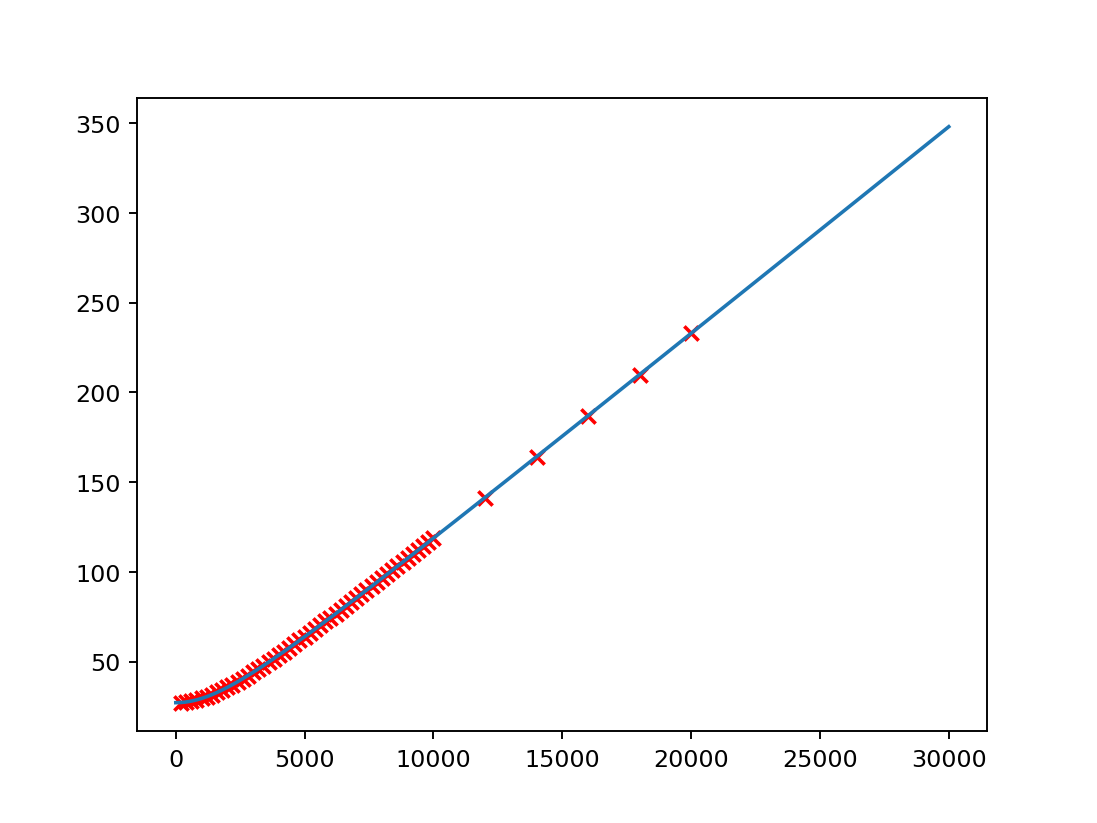

<IPython.core.display.Javascript object>


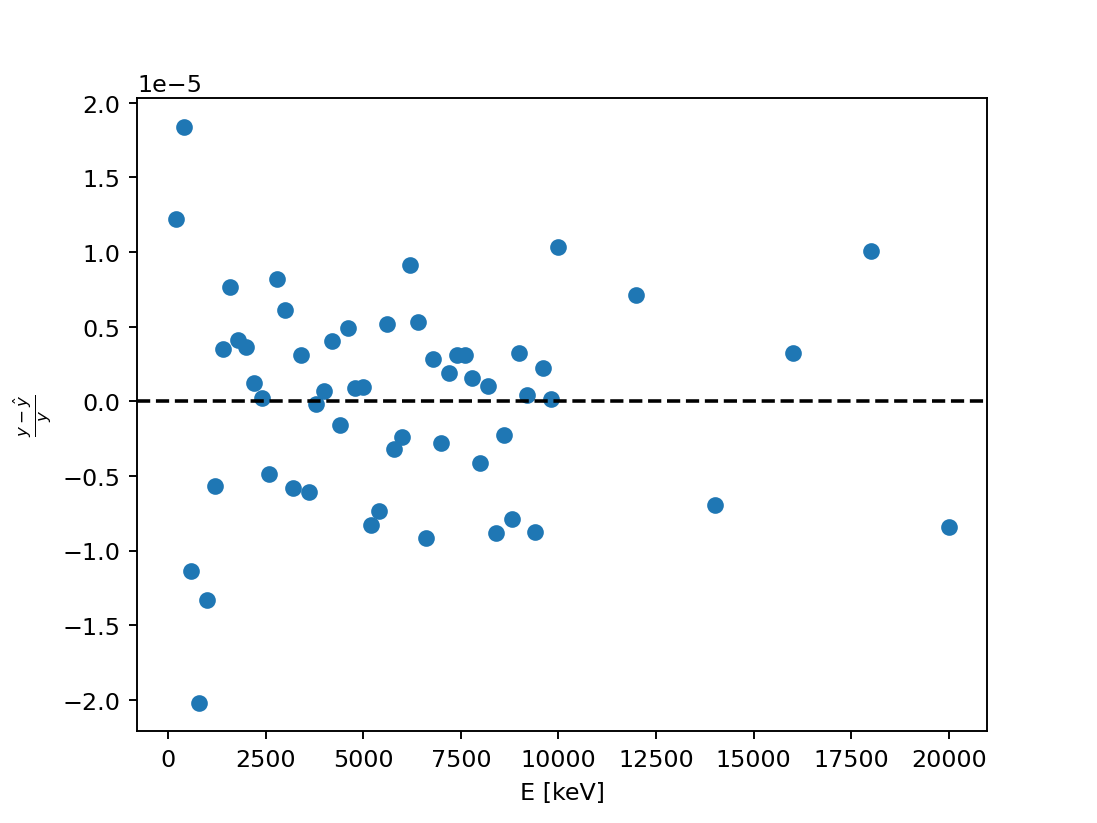

<AxesSubplot: xlabel='E [keV]', ylabel='$\\frac{y - \\hat{y}}{y}$'>

In [5]:
intp.plot(marker='x', c='r')
intp.plot_residuals()

In [ ]:
intp.a0, intp.a1, intp.a2

In [165]:
rd = om.response.ResponseData.from_db('Oscar2017')#.normalize_FWHM(1330, 30)

<IPython.core.display.Javascript object>


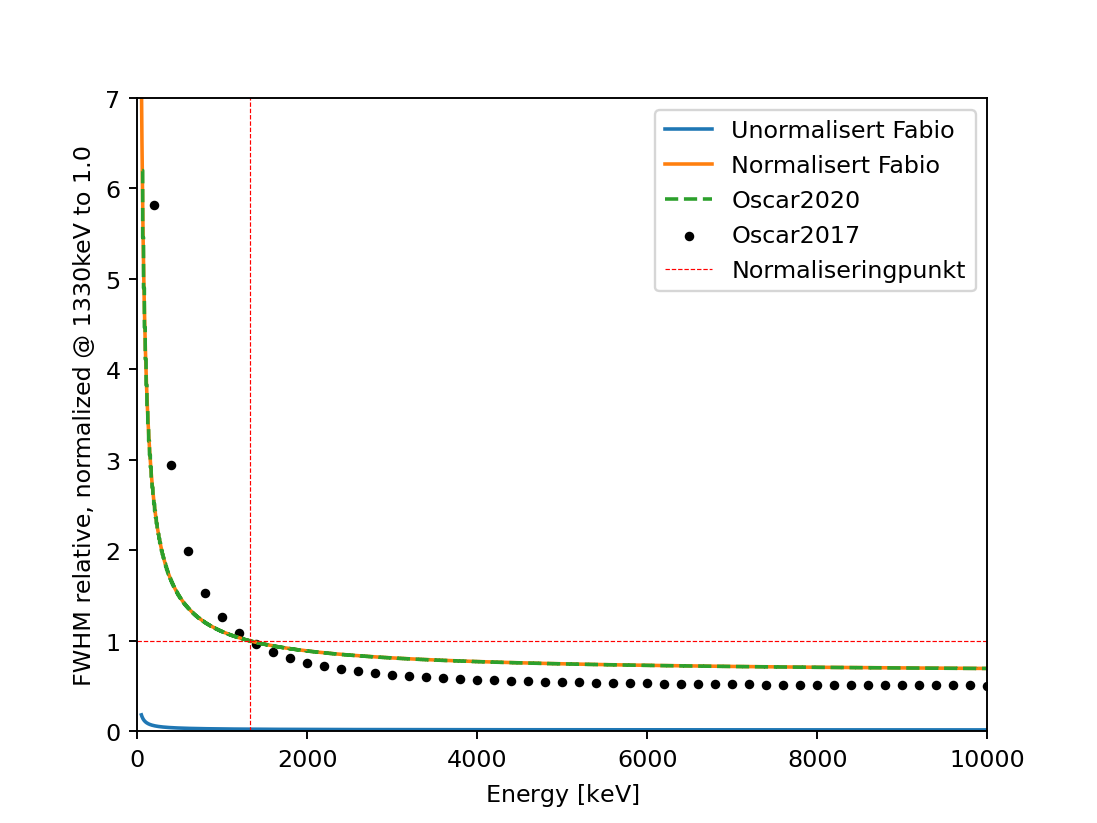

<IPython.core.display.Javascript object>


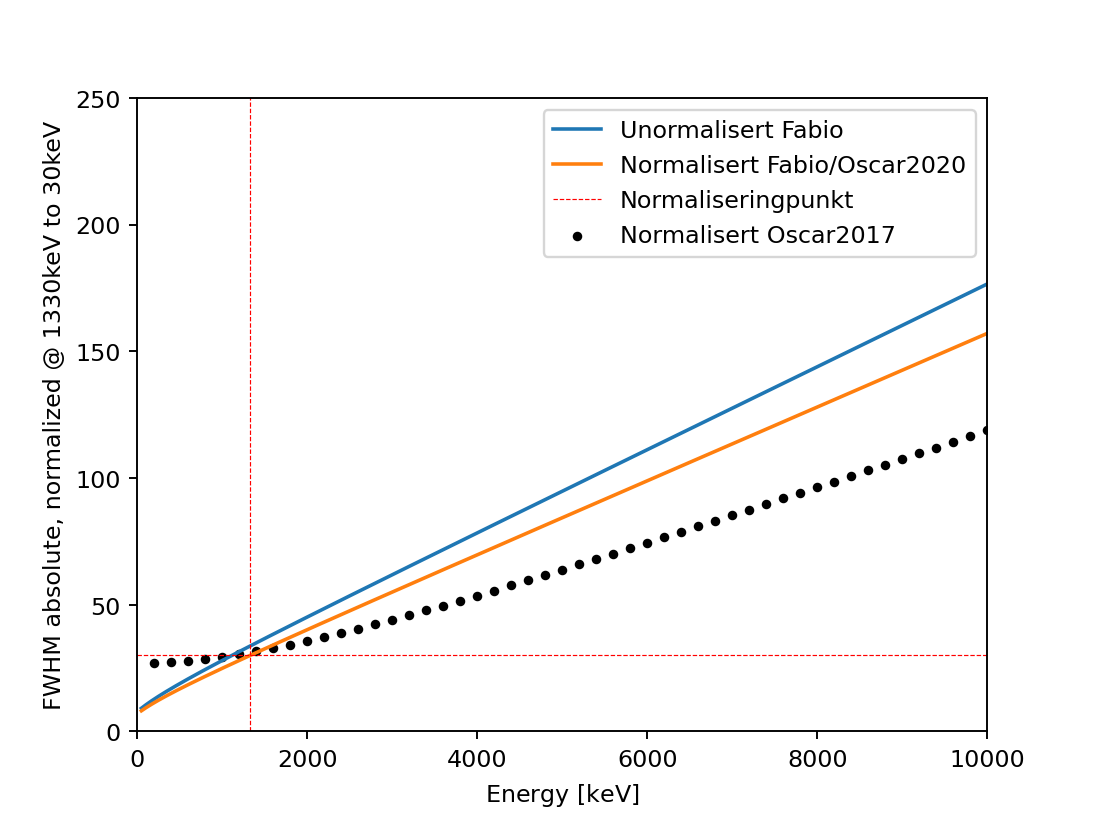

(0.0, 250.0)

In [306]:
x = np.linspace(50, 2e4, 3000)
p = (60.63, 0.458, 2.655e-4)
fwhm = lambda x: om.response.fwhm(x, *p)
g = fwhm(x)
g = om.Vector(E=x, values=g)
f = rd.FWHM

fig, ax = plt.subplots()
z = om.Vector(E=x, values=g.values/x)
z = z/z.loc[1330]
#ax.plot(x, x*(z/z.loc[1330]).values / 30)
ax.plot(x, fwhm(x) / x, label="Unormalisert Fabio")
ax.plot(x, z.values, label="Normalisert Fabio")
fwhm_.plot(ax=ax, label="Oscar2020", ls='--')
f.plot(ax=ax, label="Oscar2017", kind='dot', c='k')
ax.axhline(1.0, c='r', lw=0.5, label="Normaliseringpunkt", ls='--')
ax.axvline(1330, c='r', lw=0.5, ls='--')
ax.legend()
ax.set_ylabel("FWHM relative, normalized @ 1330keV to 1.0")
ax.set_xlim(0, 10e3)
ax.set_ylim(0, 7)

rd2 = om.response.ResponseData.from_db('Oscar2017').normalize_FWHM(1330, 30)
f2 = rd2.FWHM
fig, ax = plt.subplots()
#ax.plot(x, x*(z/z.loc[1330]).values / 30)
u = x * z * 30/1330
w = (g * 200/g.loc[6000]).values
ax.plot(x, fwhm(x), label="Unormalisert Fabio")
ax.plot(x, u, label="Normalisert Fabio/Oscar2020")
ax.axhline(30, c='r', lw=0.5, label="Normaliseringpunkt", ls='--')
ax.axvline(1330, c='r', lw=0.5, ls='--')
f2.plot(ax=ax, label="Normalisert Oscar2017", kind='dot', c='k')
#ax.plot(x, w, label="Normalisert Fabio @ 2330kev to 30 keV")
ax.legend()
ax.set_ylabel("FWHM absolute, normalized @ 1330keV to 30keV")
ax.set_xlim(0, 10e3)
ax.set_ylim(0, 250)

In [296]:
g.loc[1330]

33.82206054217857

In [ ]:
"absolutt" unormalisert fabio <- artikkel
"relativ" unormalisert fabio = absolutt unormalisert fabio / Energy



In [265]:
X = z.E
R = om.response.ResponseData.from_path('../OCL_response_functions/oscar2020/mama_export', handle_error='rebin')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 997/997 [00:02<00:00, 380.16it/s]


<IPython.core.display.Javascript object>


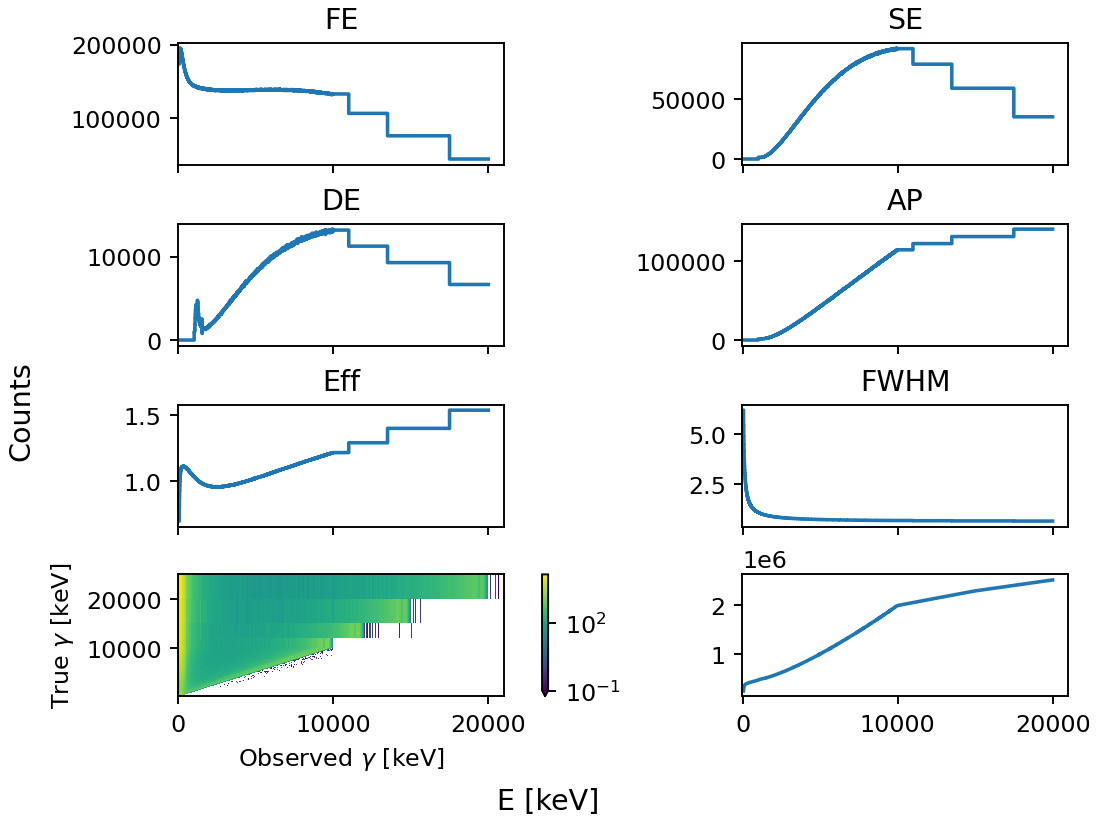

array([<AxesSubplot: title={'center': 'FE'}>,
       <AxesSubplot: title={'center': 'SE'}>,
       <AxesSubplot: title={'center': 'DE'}>,
       <AxesSubplot: title={'center': 'AP'}>,
       <AxesSubplot: title={'center': 'Eff'}>,
       <AxesSubplot: title={'center': 'FWHM'}>,
       <AxesSubplot: xlabel='Observed $\\gamma$ [$\\mathrm{keV}$]', ylabel='True $\\gamma$ [$\\mathrm{keV}$]'>,
       <AxesSubplot: >], dtype=object)

In [268]:
R.plot()

<IPython.core.display.Javascript object>


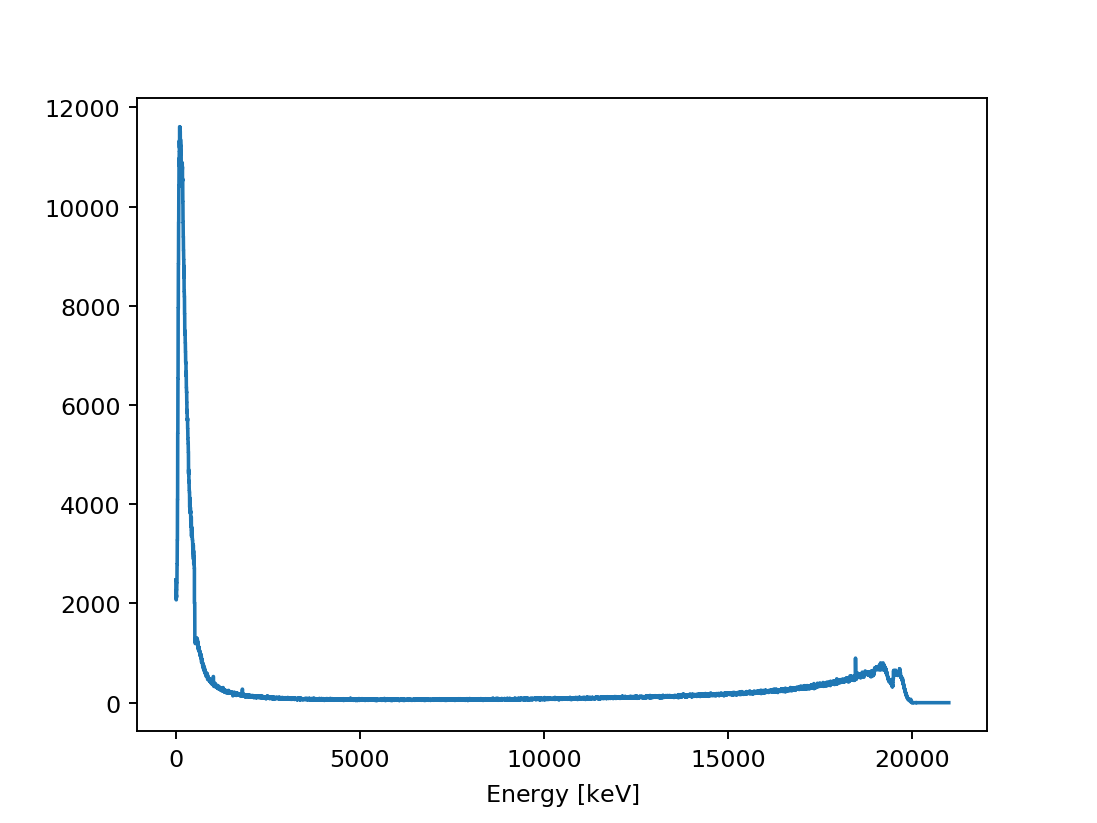

<AxesSubplot: xlabel='Energy [$\\mathrm{keV}$]'>

In [272]:
R.compton[-1].plot()

<IPython.core.display.Javascript object>


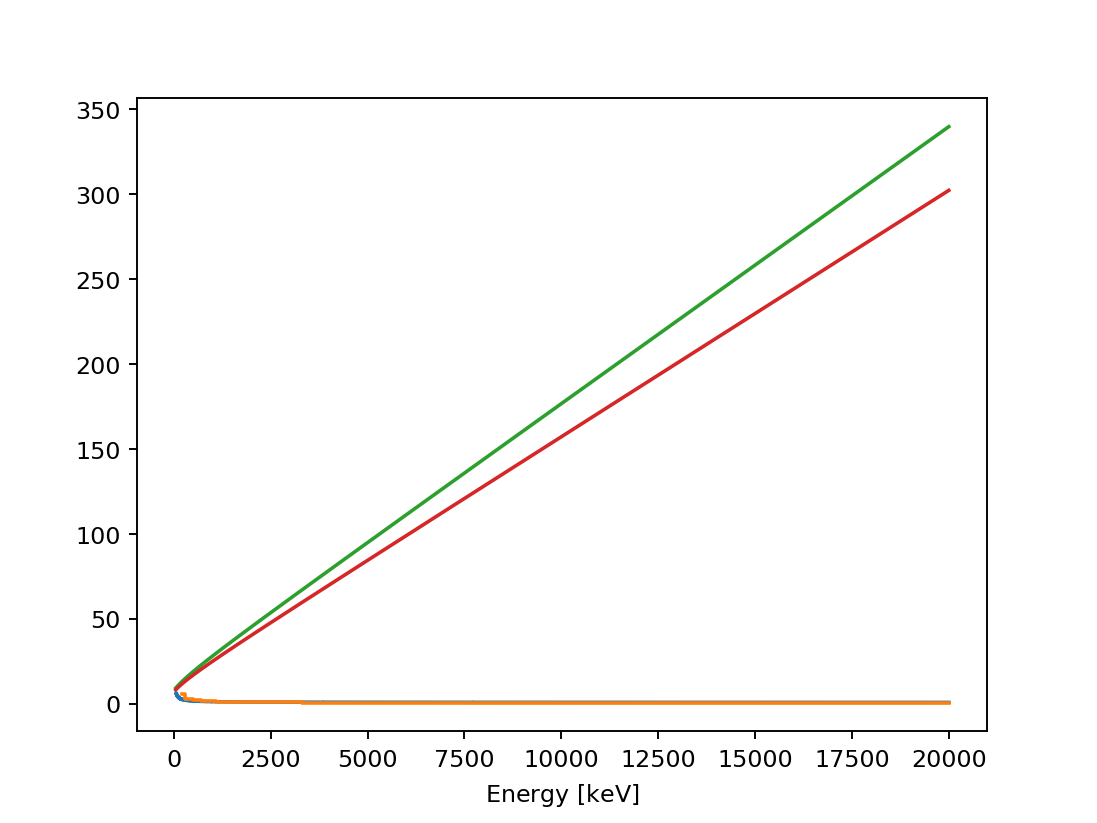

In [281]:
fwhm_ = R.FWHM
ax = fwhm_.plot()
rd.FWHM.plot(ax=ax)
ax.plot(x, fwhm(x), label="Unormalisert Fabio")
ax.plot(x, u, label="Normalisert Fabio")

In [273]:
rd3 = om.response.DiscreteInterpolation.from_data(R)

ValueError: FWHM must be normalized before interpolation, at least until bug is fixed in FWHM creation

<IPython.core.display.Javascript object>


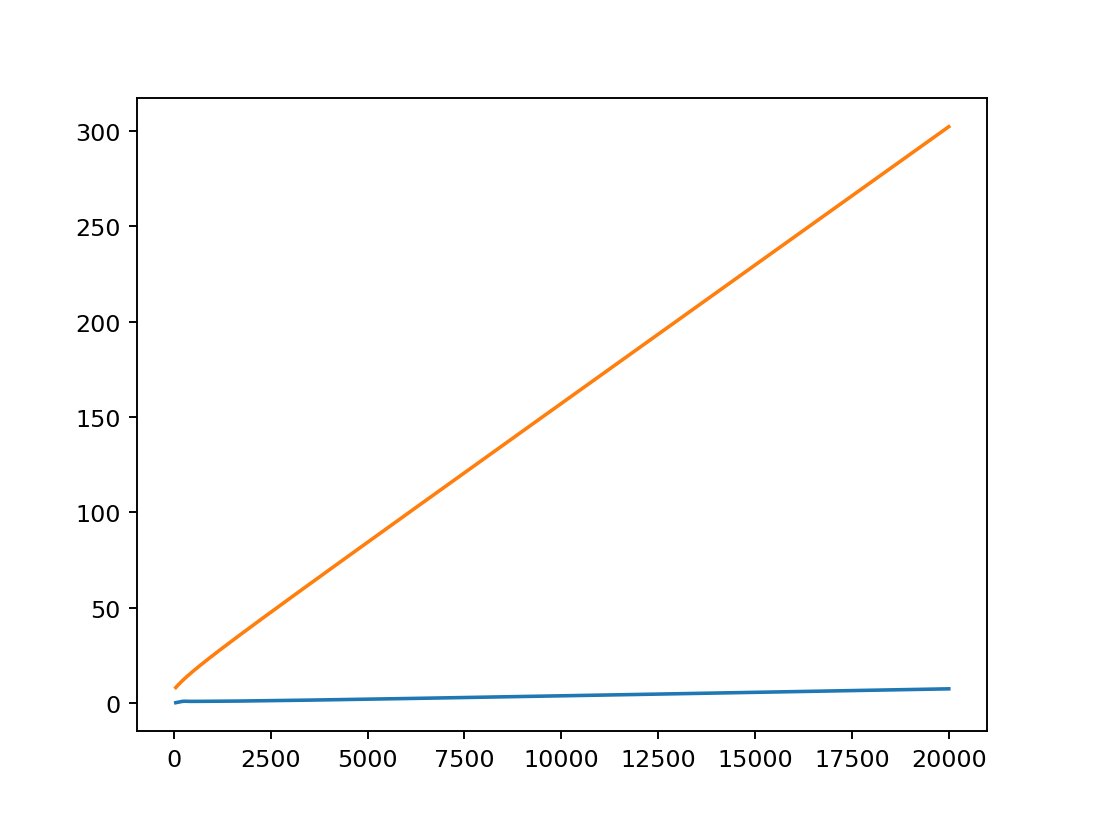

In [231]:
fig, ax = plt.subplots()
ax.plot(X, *R.f_fwhm_rel_perCent_norm(X))
ax.plot(X, u)

In [149]:
p = (60.63, 0.458, 2.655e-4)
x = np.linspace(1, 20e3)
f = lambda x: om.response.fwhm(x, *p)
y = om.response.fwhm(x, *p)
vec = om.Vector(E=x, values=y)
#fwhm = lambda x: om.response.FWHMInterpolation(x, *p)

<IPython.core.display.Javascript object>


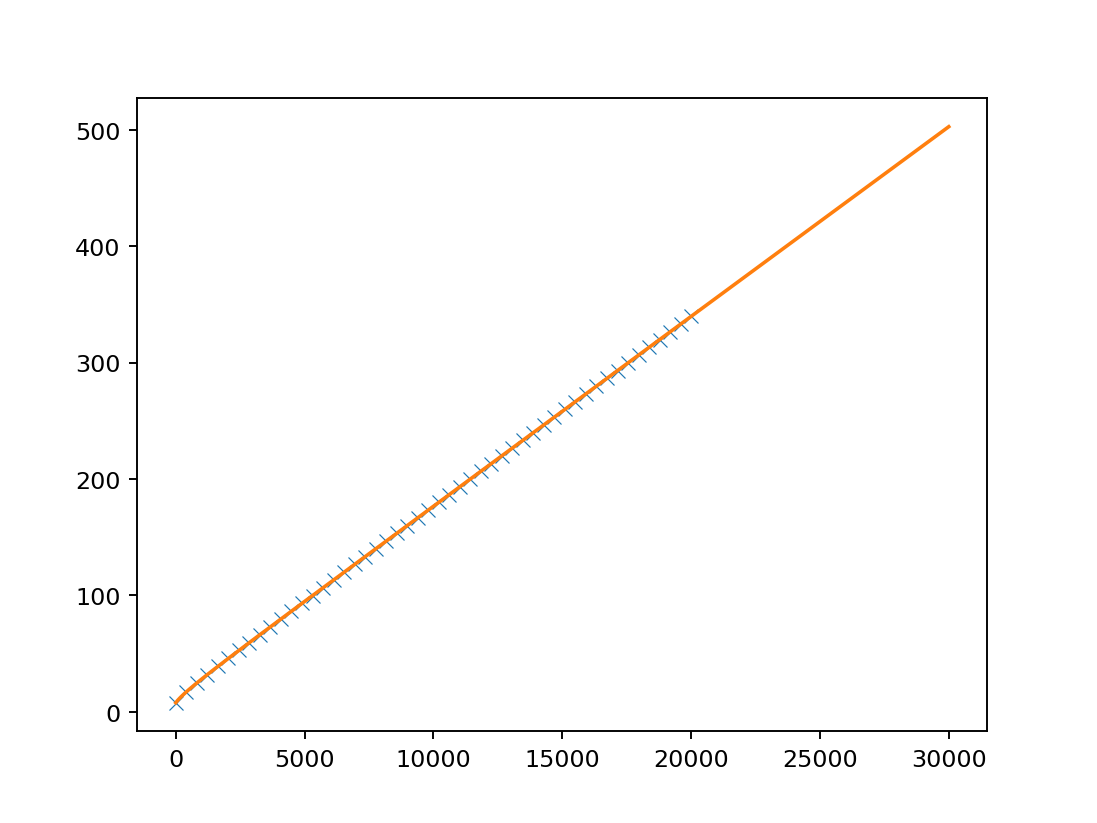

<AxesSubplot: >

In [134]:
fwhm.plot()

<IPython.core.display.Javascript object>


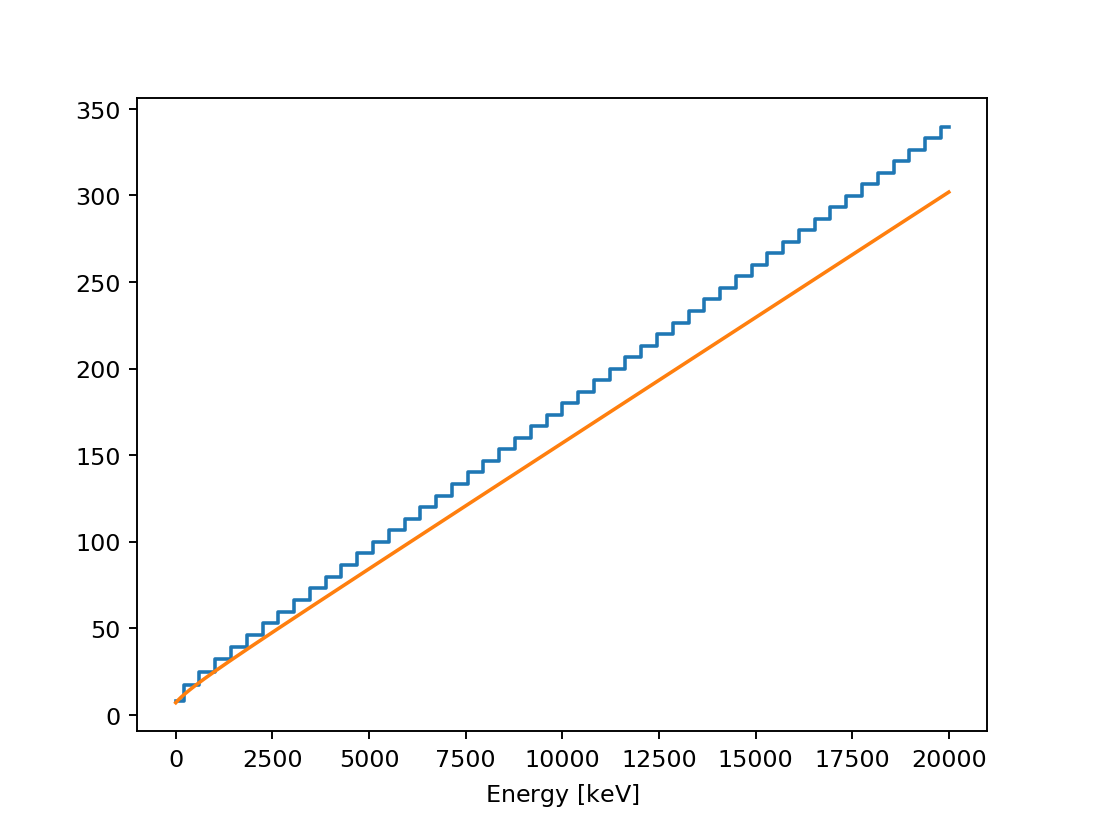

In [156]:
ax = vec.plot()
z = 30 / f(1330) * f(x)
ax.plot(x, z)

## FE

In [113]:
rd = om.ResponseData.from_db('Oscar2017').scale()

In [97]:
intpo = om.response.FEInterpolator(rd.FE)

In [104]:
intp = intpo.interpolate(order=9, linear_num_points=3)

<IPython.core.display.Javascript object>


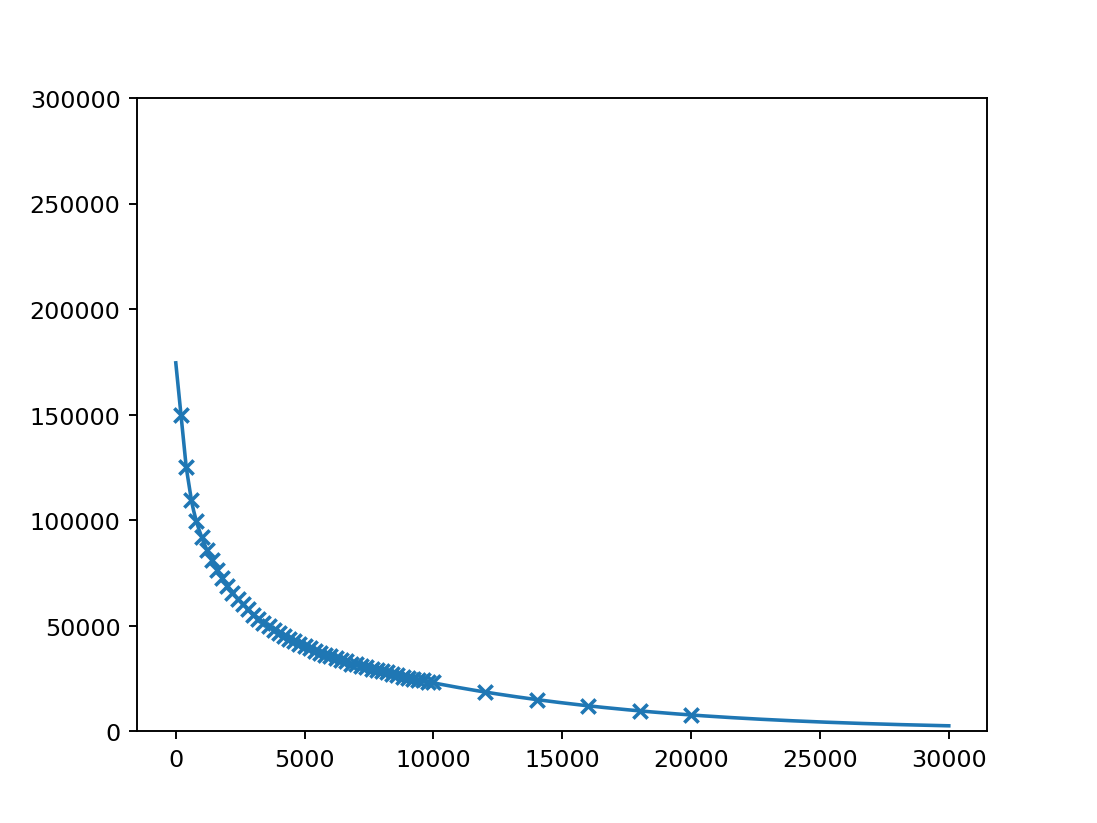

<IPython.core.display.Javascript object>


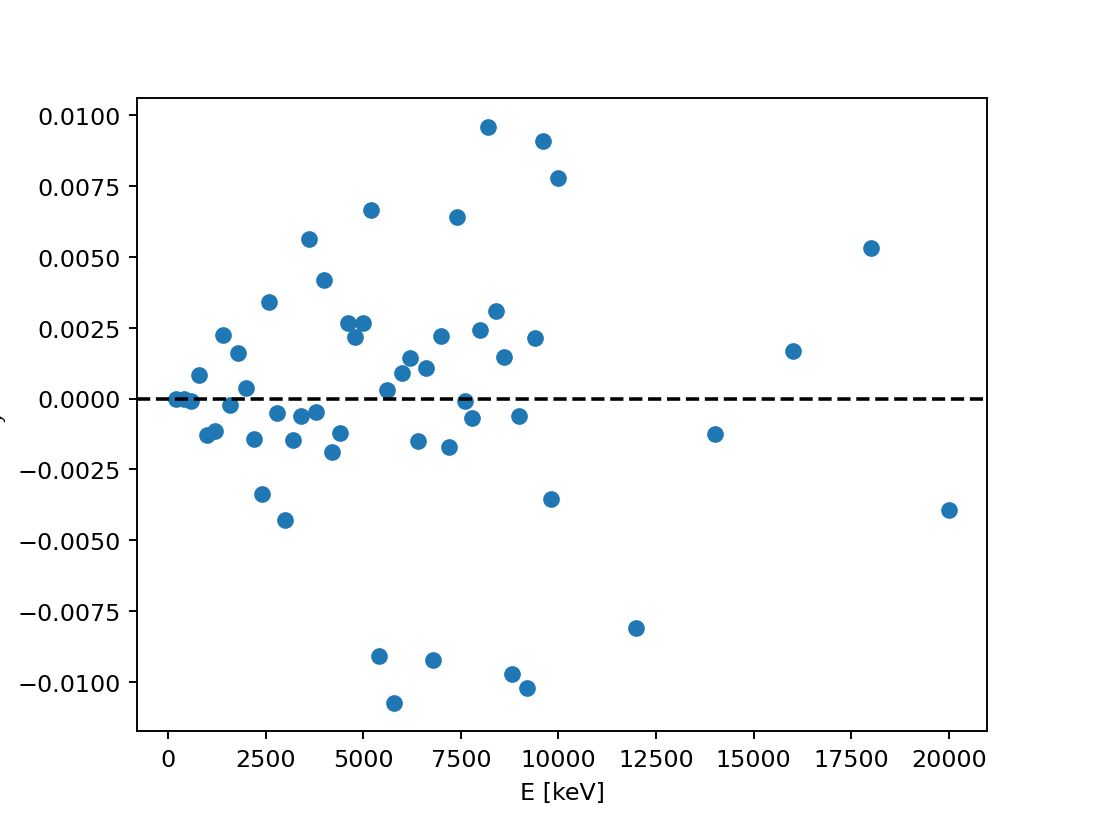

<AxesSubplot: xlabel='E [keV]', ylabel='$\\frac{y - \\hat{y}}{y}$'>

In [105]:
ax = intp.plot()
ax.set_ylim(0, 2*intp.points.max())
intp.plot_residuals()

In [96]:
print(intp)

FE logarithmic polynomial of order 9:
 p0:  4.01e+03 ±  2.4e+02
 p1: -4.56e+03 ±  2.5e+02
 p2:  2.25e+03 ±  1.1e+02
 p3: -6.28e+02 ±  2.8e+01
 p4:  1.09e+02 ±  4.6e+00
 p5: -1.19e+01 ±  5.0e-01
 p6:  8.05e-01 ±  3.5e-02
 p7: -3.08e-02 ±  1.4e-03
 p8:  5.12e-04 ±  2.5e-05



<IPython.core.display.Javascript object>


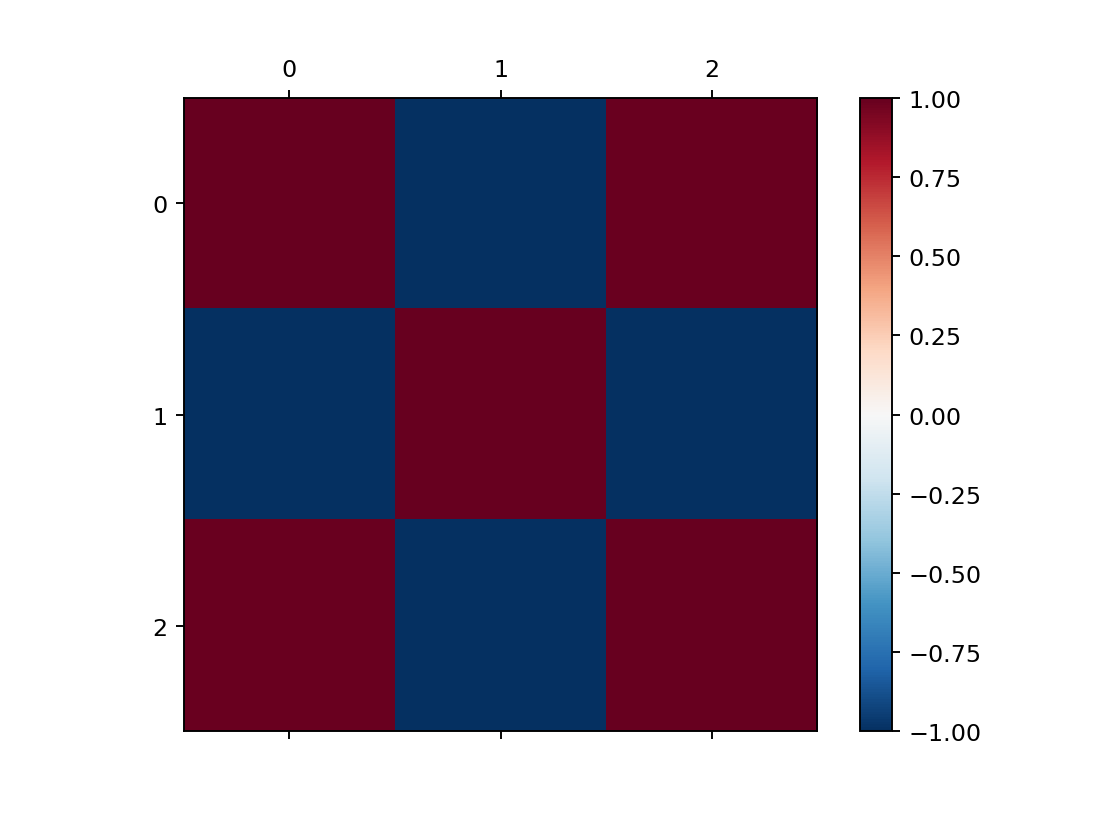

<AxesSubplot: >

In [80]:
intpo.plot_cor()

<IPython.core.display.Javascript object>


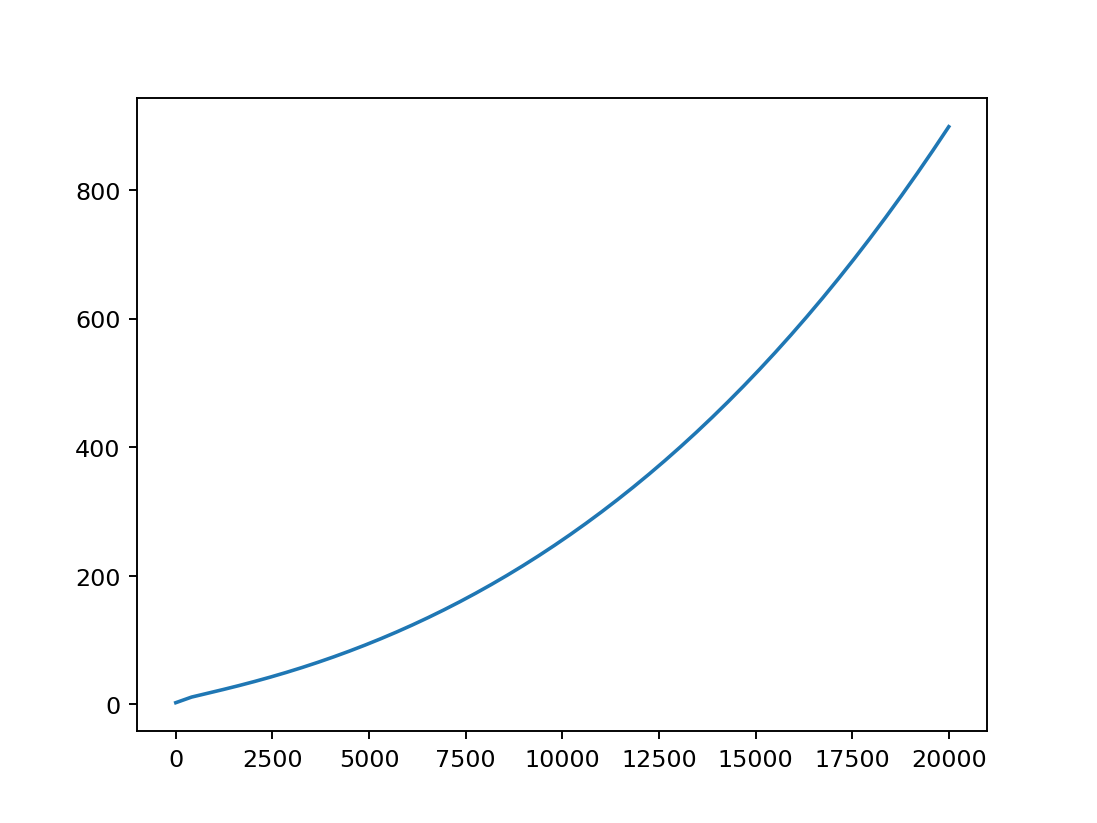

In [46]:
fig, ax = plt.subplots()
x = np.linspace(0, 2e4)
y = om.response.interpolations.polylog(x, *intp.p)
ax.plot(x, y)

In [47]:
y

array([  2.71828183,  11.42911049,  17.28565644,  23.16397223,
        29.28424739,  35.72801427,  42.53820415,  49.74268884,
        57.36233487,  65.41438174,  73.91405877,  82.87543502,
        92.31189831, 102.23644069, 112.66183602, 123.60075466,
       135.06583988, 147.06976009, 159.6252454 , 172.74511386,
       186.44229051, 200.72982162, 215.62088543, 231.12880049,
       247.26703211, 264.04919764, 281.48907067, 299.60058458,
       318.3978355 , 337.89508493, 358.106762  , 379.04746545,
       400.73196557, 423.17520582, 446.3923045 , 470.39855621,
       495.20943337, 520.84058757, 547.307851  , 574.62723774,
       602.8149451 , 631.88735496, 661.86103503, 692.75274017,
       724.57941367, 757.35818854, 791.10638879, 825.84153076,
       861.58132436, 898.34367442])

In [17]:
total = rd.FE + rd.SE + rd.DE + rd.AP + rd.compton_sum()
a = (total / rd.Eff)
ax = a.plot()
median = np.median(a)
ax.axhline(np.median(a))
b = a / median
fe = rd.DE / b
b.plot()
ax = fe.plot()
rd.DE.plot(ax=ax)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<AxesSubplot: xlabel='Energy [$\\mathrm{keV}$]'>

In [8]:
rd.Eff.plot()

<IPython.core.display.Javascript object>

<AxesSubplot: xlabel='Energy [$\\mathrm{keV}$]'>

<IPython.core.display.Javascript object>


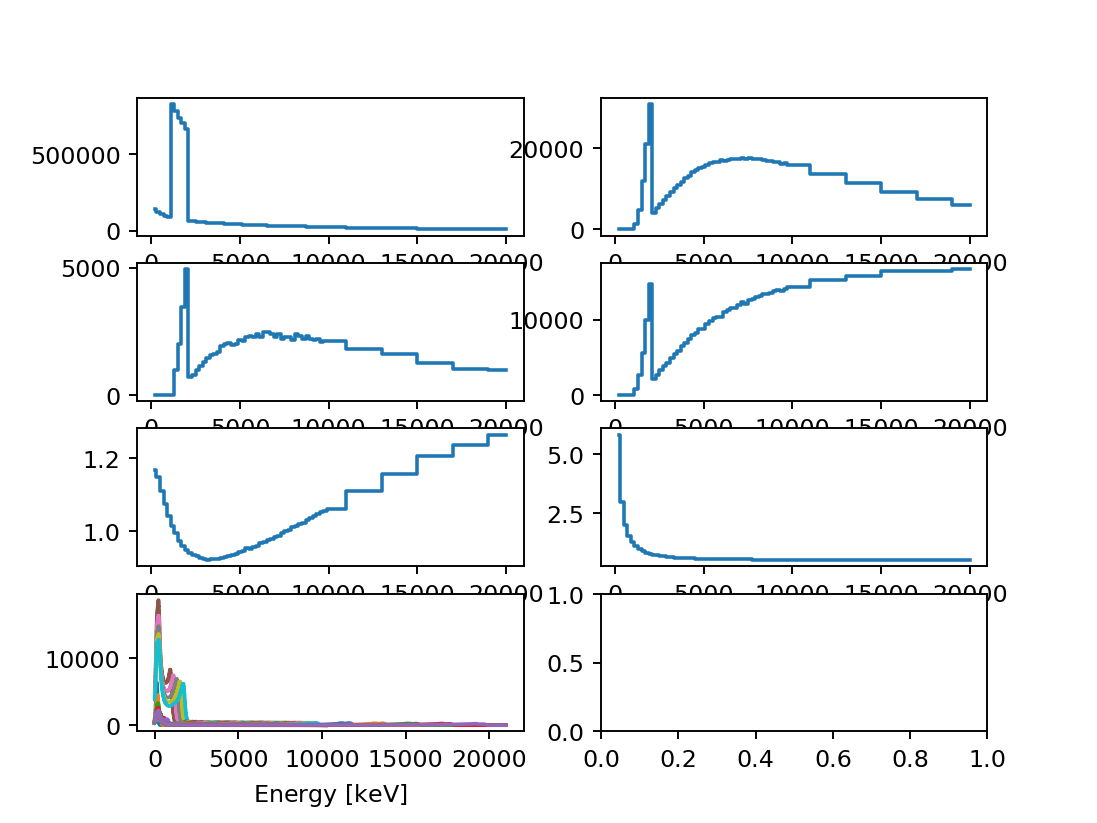

array([<AxesSubplot: xlabel='Energy [$\\mathrm{keV}$]'>,
       <AxesSubplot: xlabel='Energy [$\\mathrm{keV}$]'>,
       <AxesSubplot: xlabel='Energy [$\\mathrm{keV}$]'>,
       <AxesSubplot: xlabel='Energy [$\\mathrm{keV}$]'>,
       <AxesSubplot: xlabel='Energy [$\\mathrm{keV}$]'>,
       <AxesSubplot: xlabel='Energy [$\\mathrm{keV}$]'>,
       <AxesSubplot: xlabel='Energy [$\\mathrm{keV}$]'>, <AxesSubplot: >],
      dtype=object)

In [18]:
rd.plot()

<IPython.core.display.Javascript object>


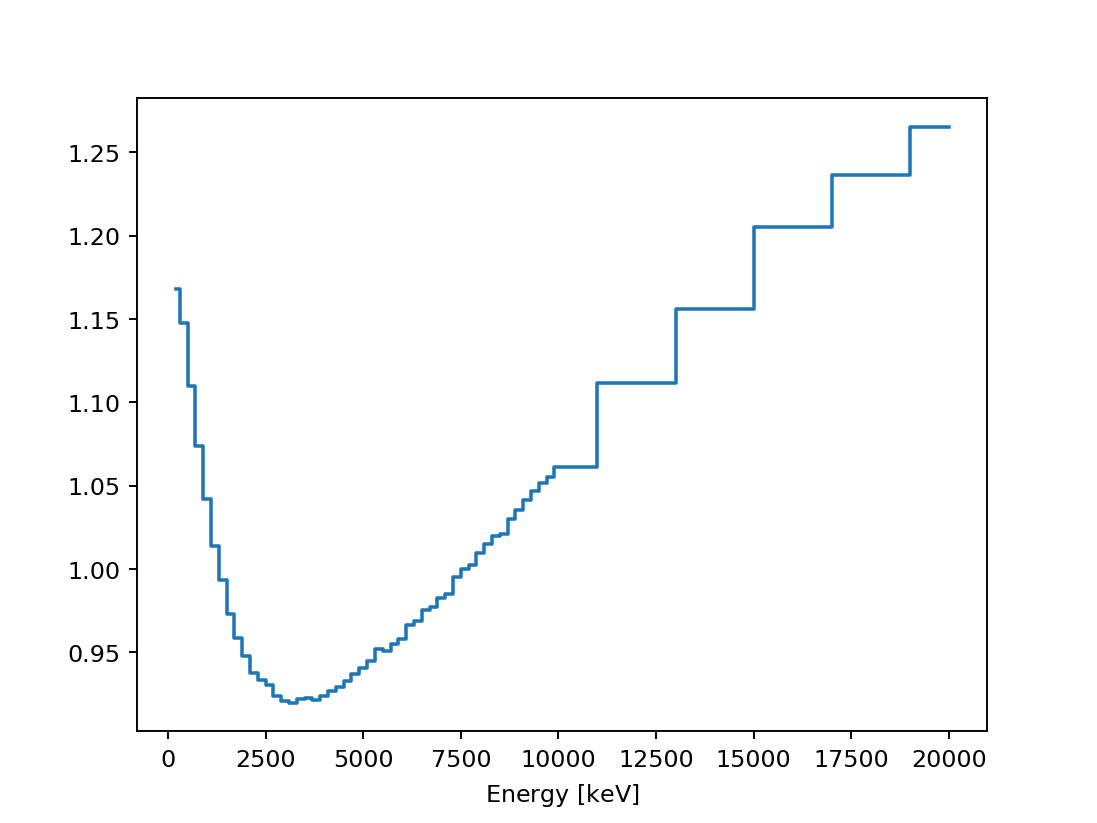

<AxesSubplot: xlabel='Energy [$\\mathrm{keV}$]'>

In [106]:
rd.Eff.plot()

<IPython.core.display.Javascript object>


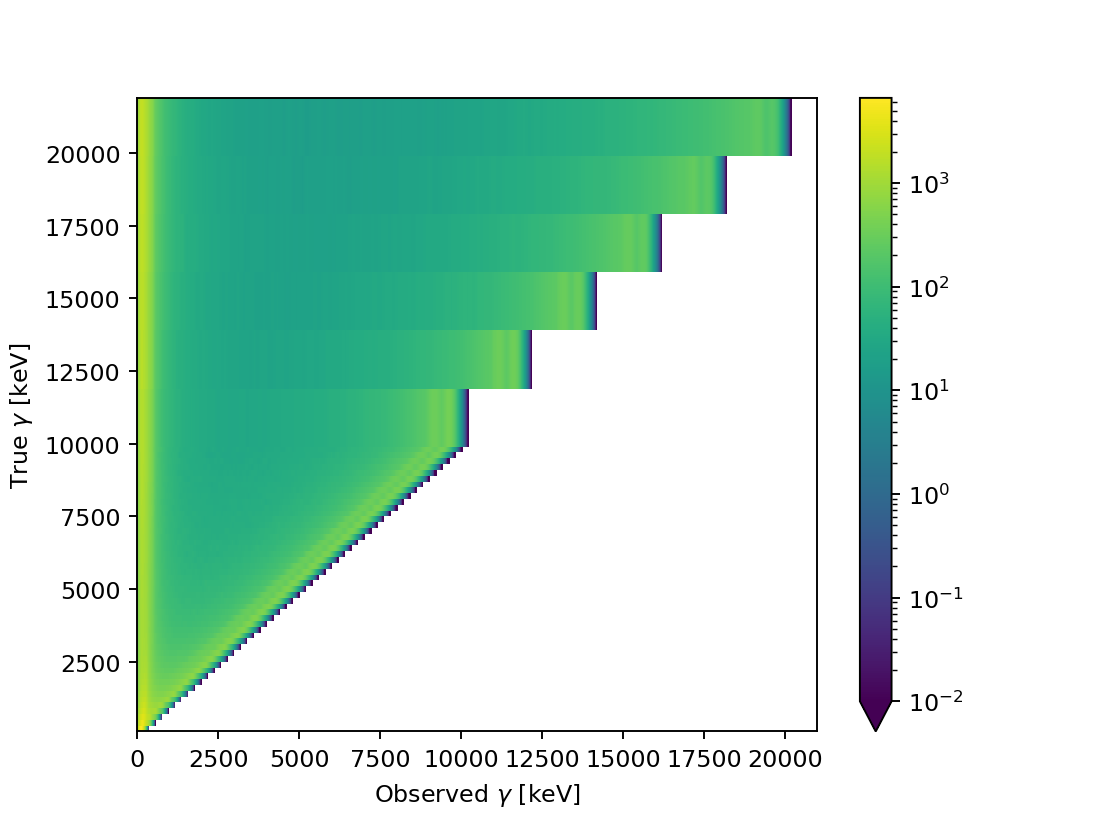

(<AxesSubplot: xlabel='Observed $\\gamma$ [$\\mathrm{keV}$]', ylabel='True $\\gamma$ [$\\mathrm{keV}$]'>,
 (<matplotlib.collections.QuadMesh at 0x7ff592bed900>,
  <matplotlib.colorbar.Colorbar at 0x7ff5928848b0>))

In [23]:
rd.scale().compton_matrix().plot()

## Response

In [86]:
rd = om.response.ResponseData.from_db('Oscar2017').normalize_FWHM(1330, 30)

In [87]:
rdi = om.response.DiscreteInterpolation.from_data(rd)

<IPython.core.display.Javascript object>


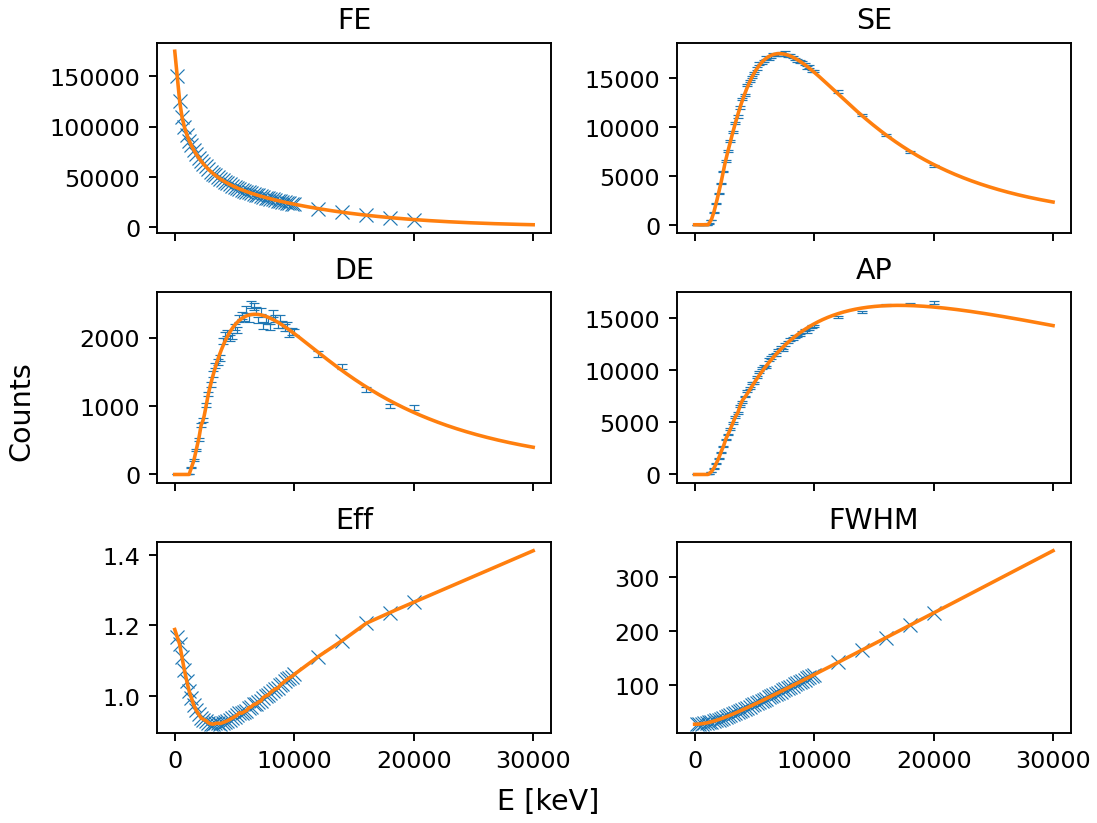

array([<AxesSubplot: title={'center': 'FE'}>,
       <AxesSubplot: title={'center': 'SE'}>,
       <AxesSubplot: title={'center': 'DE'}>,
       <AxesSubplot: title={'center': 'AP'}>,
       <AxesSubplot: title={'center': 'Eff'}>,
       <AxesSubplot: title={'center': 'FWHM'}>], dtype=object)

In [88]:
rdi.plot()

<IPython.core.display.Javascript object>


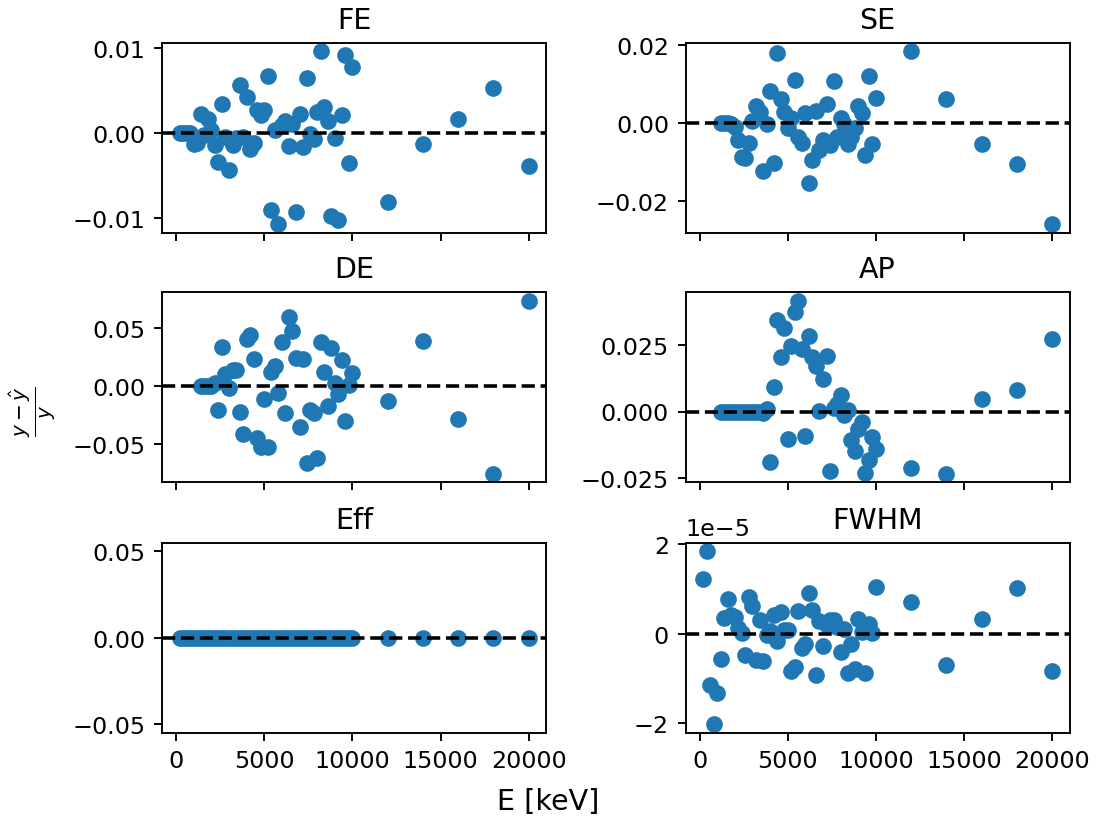

array([<AxesSubplot: title={'center': 'FE'}>,
       <AxesSubplot: title={'center': 'SE'}>,
       <AxesSubplot: title={'center': 'DE'}>,
       <AxesSubplot: title={'center': 'AP'}>,
       <AxesSubplot: title={'center': 'Eff'}>,
       <AxesSubplot: title={'center': 'FWHM'}>], dtype=object)

In [134]:
rdi.plot_residuals()

In [34]:
rdi.save('di1')

In [35]:
rdi2 = om.response.DiscreteInterpolation.from_path('di1')

In [36]:
print(rdi2)

Interpolation of discrete response structures using:
FE: FE logarithmic polynomial of order 9:
 p0:  4.01e+03 ±  2.4e+02
 p1: -4.56e+03 ±  2.5e+02
 p2:  2.25e+03 ±  1.1e+02
 p3: -6.28e+02 ±  2.8e+01
 p4:  1.09e+02 ±  4.6e+00
 p5: -1.19e+01 ±  5.0e-01
 p6:  8.05e-01 ±  3.5e-02
 p7: -3.08e-02 ±  1.4e-03
 p8:  5.12e-04 ±  2.5e-05

SE: EscapeInterpolation()
DE: EscapeInterpolation()
AP: AnnihilationInterpolation()
Eff: LinearInterpolation()
FWHM: FWHMInterpolation:
 a0:  7.35e+02 ±  7.8e-03
 a1:  6.47e-06 ±  3.8e-06
 a2:  1.34e-04 ±  3.4e-10



<IPython.core.display.Javascript object>


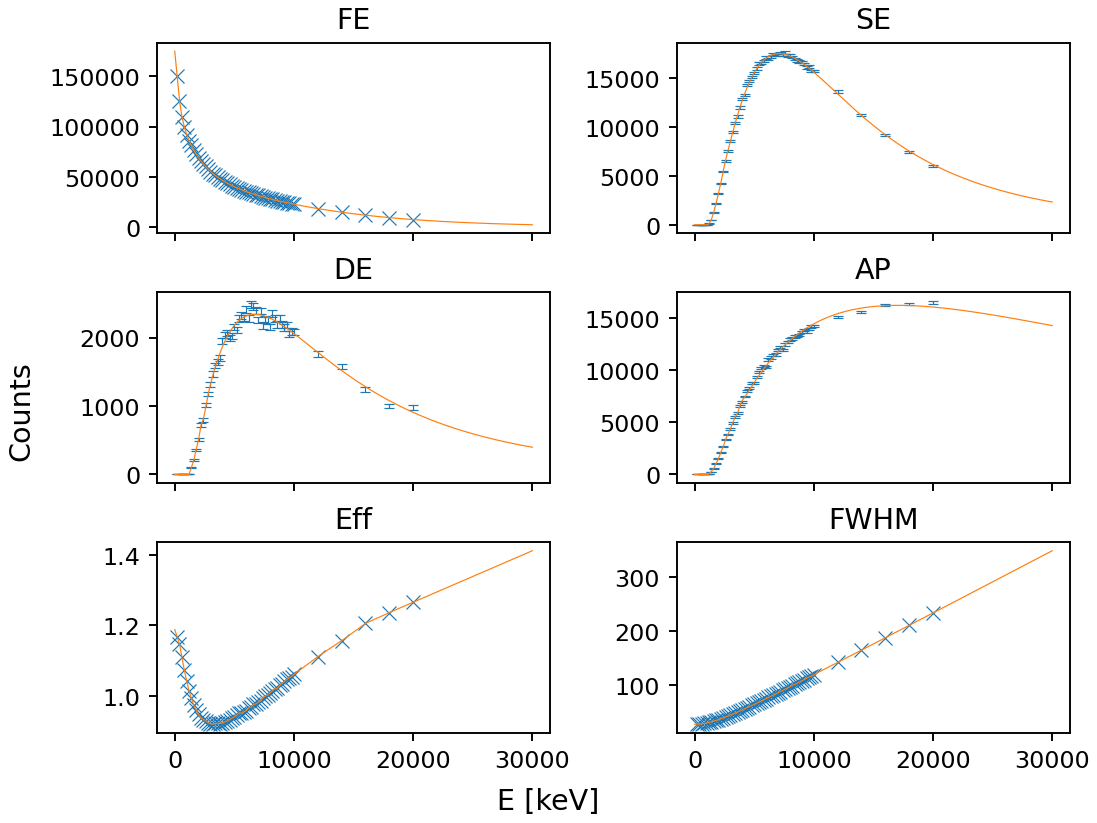

array([<AxesSubplot: title={'center': 'FE'}>,
       <AxesSubplot: title={'center': 'SE'}>,
       <AxesSubplot: title={'center': 'DE'}>,
       <AxesSubplot: title={'center': 'AP'}>,
       <AxesSubplot: title={'center': 'Eff'}>,
       <AxesSubplot: title={'center': 'FWHM'}>], dtype=object)

In [70]:
rdi.plot(lw=0.5)

<IPython.core.display.Javascript object>


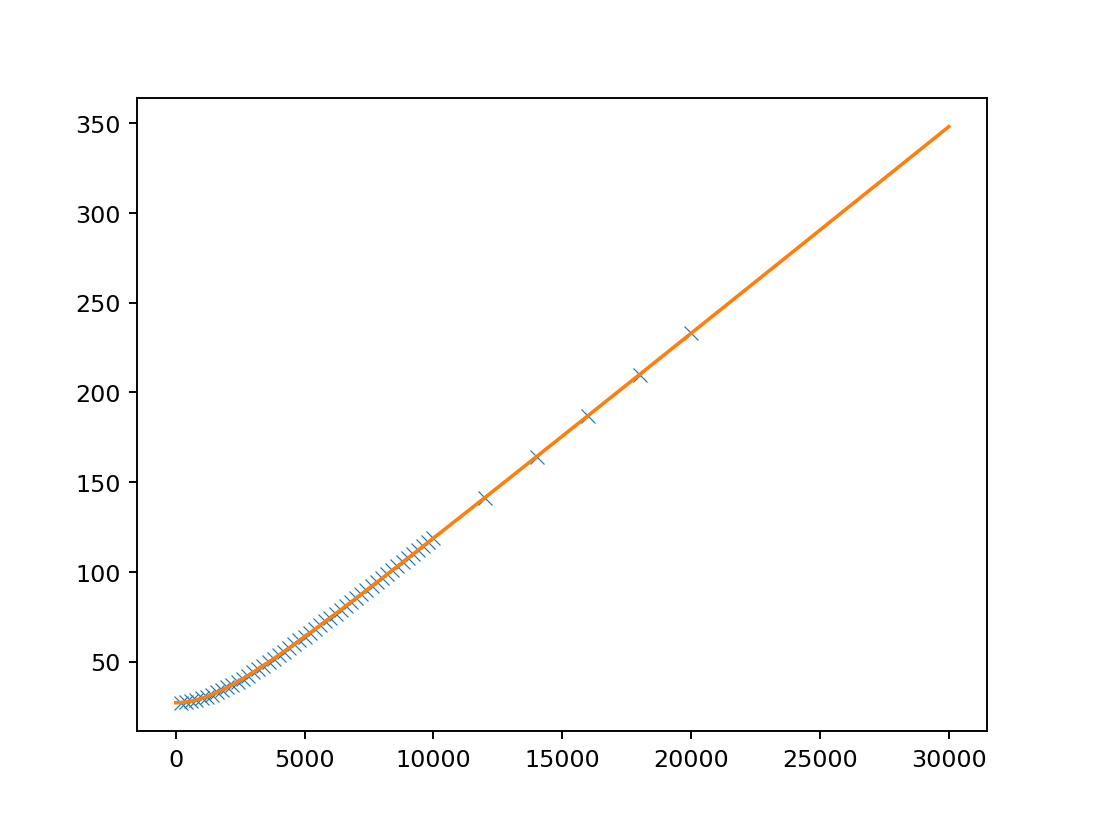

<AxesSubplot: >

In [73]:
rdi.FWHM.plot()

<IPython.core.display.Javascript object>


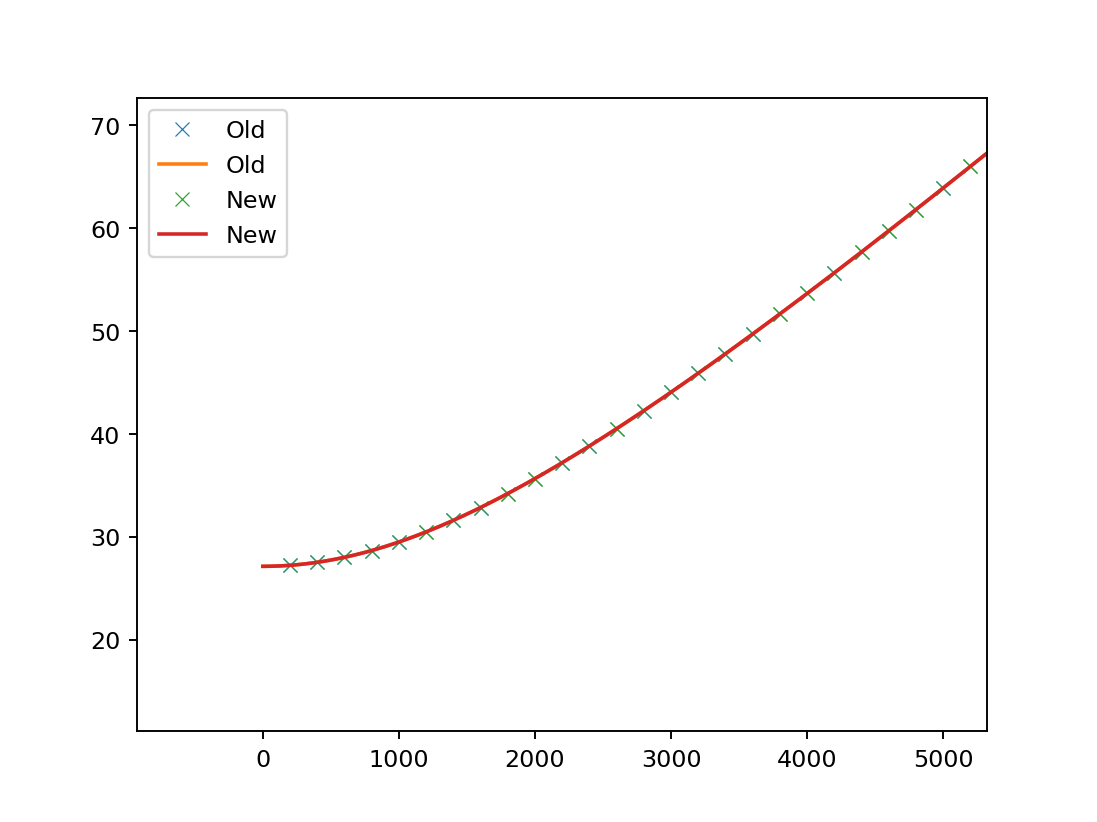

In [80]:
FWHM = om.response.FWHMInterpolation
f = rdi.FWHM
fwhm = FWHM(f.points, f.a0, f.a1, f.a2)
ax = f.plot(label='Old')
fwhm.plot(ax=ax, label='New')
ax.legend()

In [81]:
fwhm(1330) 

array([31.1716659])

<IPython.core.display.Javascript object>


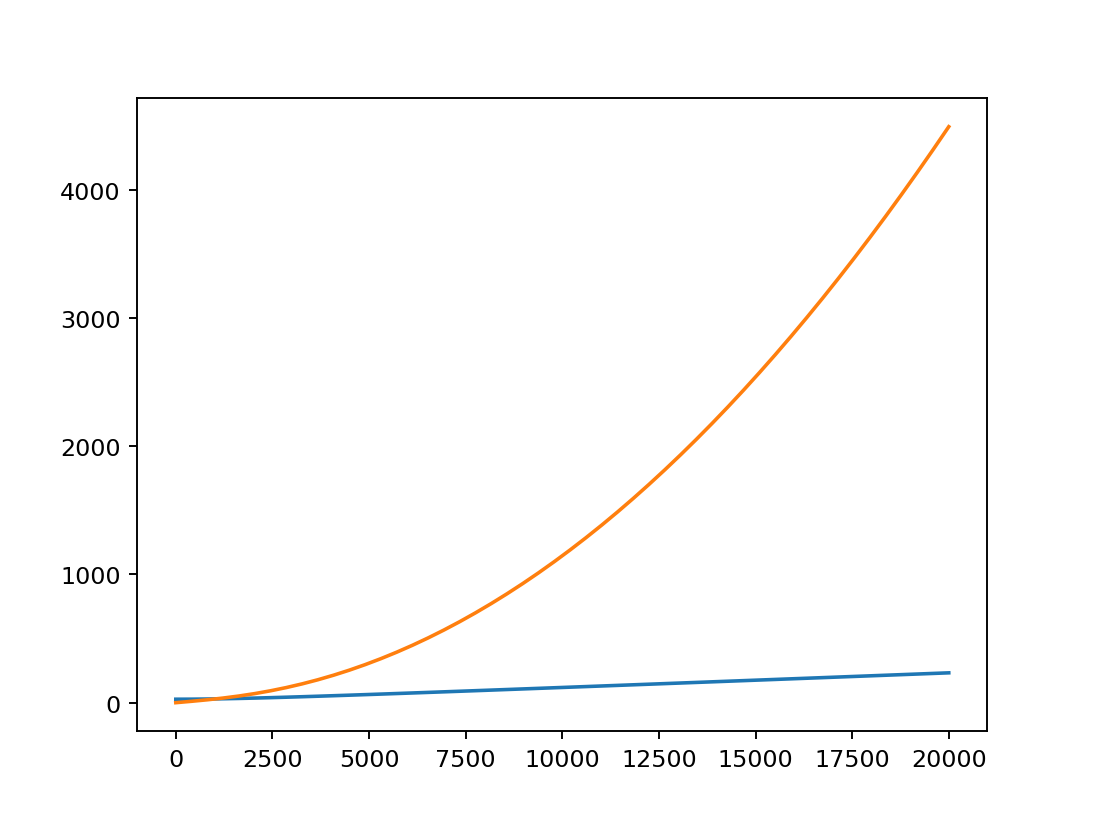

In [103]:
x = np.linspace(1e-1, 20e3)
y = fwhm(x)
fig, ax = plt.subplots()
z = y * 40 / fwhm(1330) * x / 1330
ax.plot(x, y)
ax.plot(x, z)

<IPython.core.display.Javascript object>


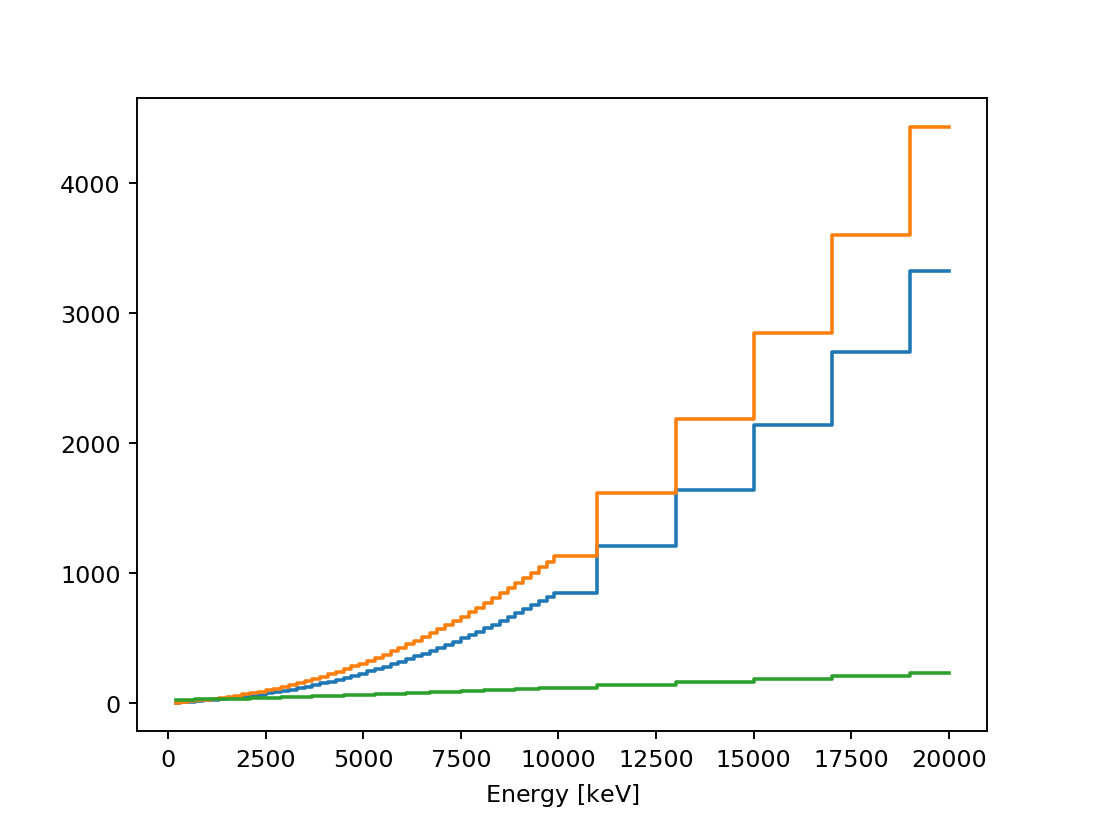

<AxesSubplot: xlabel='Energy [$\\mathrm{keV}$]'>

In [107]:
rd2 = rd.normalize_FWHM(1330, 30)
ax = rd2.FWHM.plot()
rd3 = rd.normalize_FWHM(1330, 40)
rd3.FWHM.plot(ax=ax)
rd.FWHM.plot(ax=ax)

In [110]:
clean = om.response.ResponseData.from_db('Oscar2017')

<IPython.core.display.Javascript object>


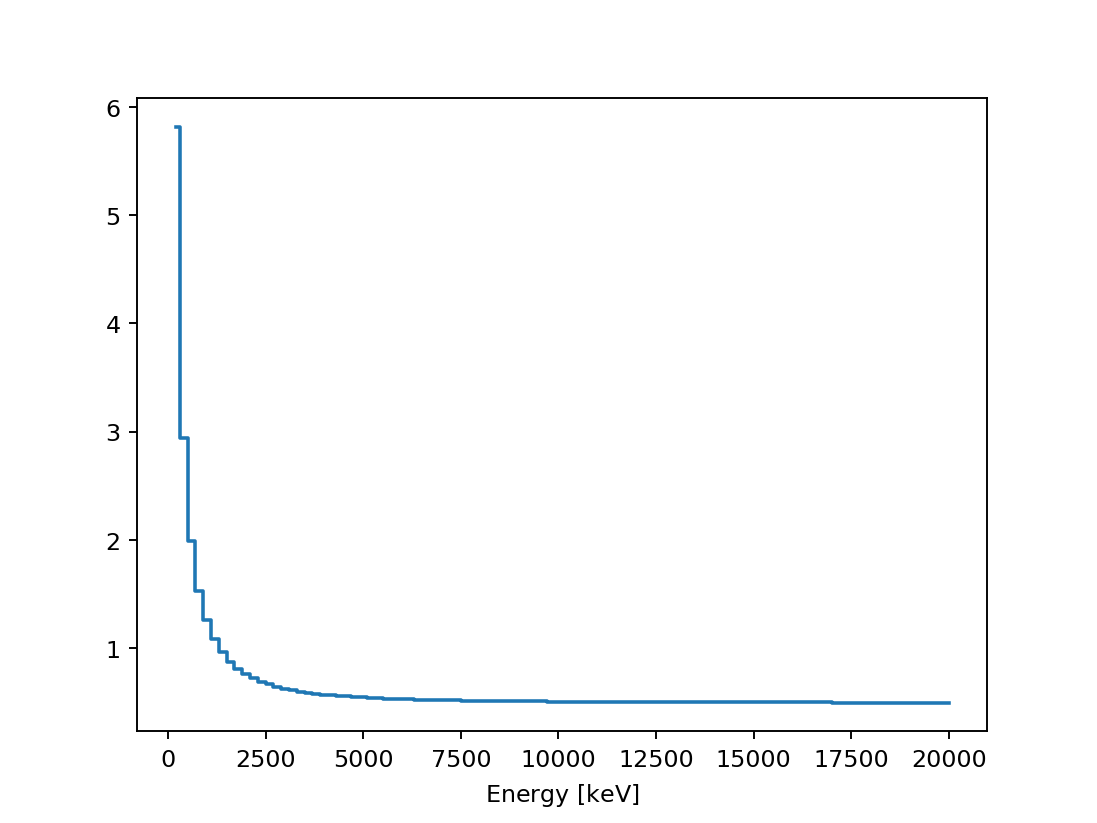

<AxesSubplot: xlabel='Energy [$\\mathrm{keV}$]'>

In [111]:
clean.FWHM.plot()

<IPython.core.display.Javascript object>


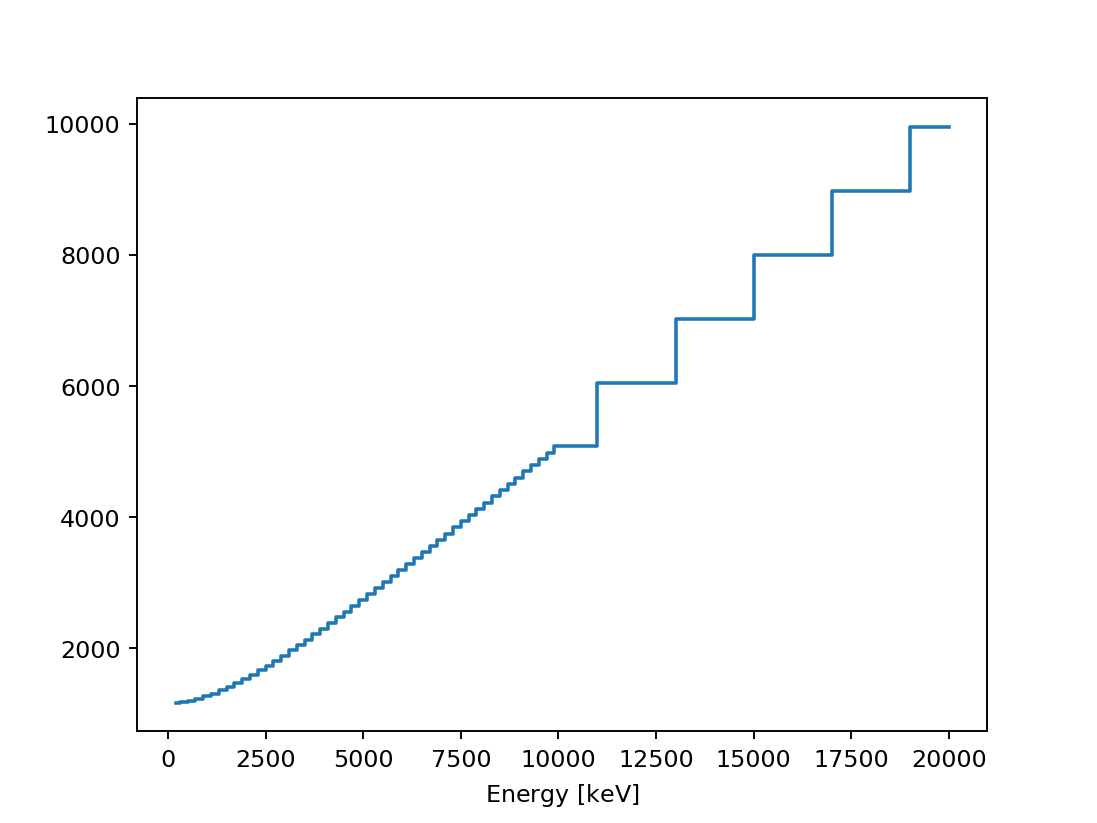

<AxesSubplot: xlabel='Energy [$\\mathrm{keV}$]'>

In [112]:
f = clean.FWHM
g = f * f.E
g.plot()

# 167Ho

In [ ]:
holm = om.Matrix(path="./167Ho_raw.m")
holm2 = om.Matrix(path="./167Ho_raw_with_bg.m")

In [ ]:
holm = holm.loc[:'13MeV', :'8MeV']
line = om.Line(slope=1, p1=(0,0))
holm[line.above(holm)] = 0
ax, _ = holm.plot()
line.plot(holm, ax=ax)

In [ ]:
holm.summary()

In [ ]:
holm2.plot()

In [ ]:
bg = holm2 - holm
bg.plot()